# Russian Ads Text Generation

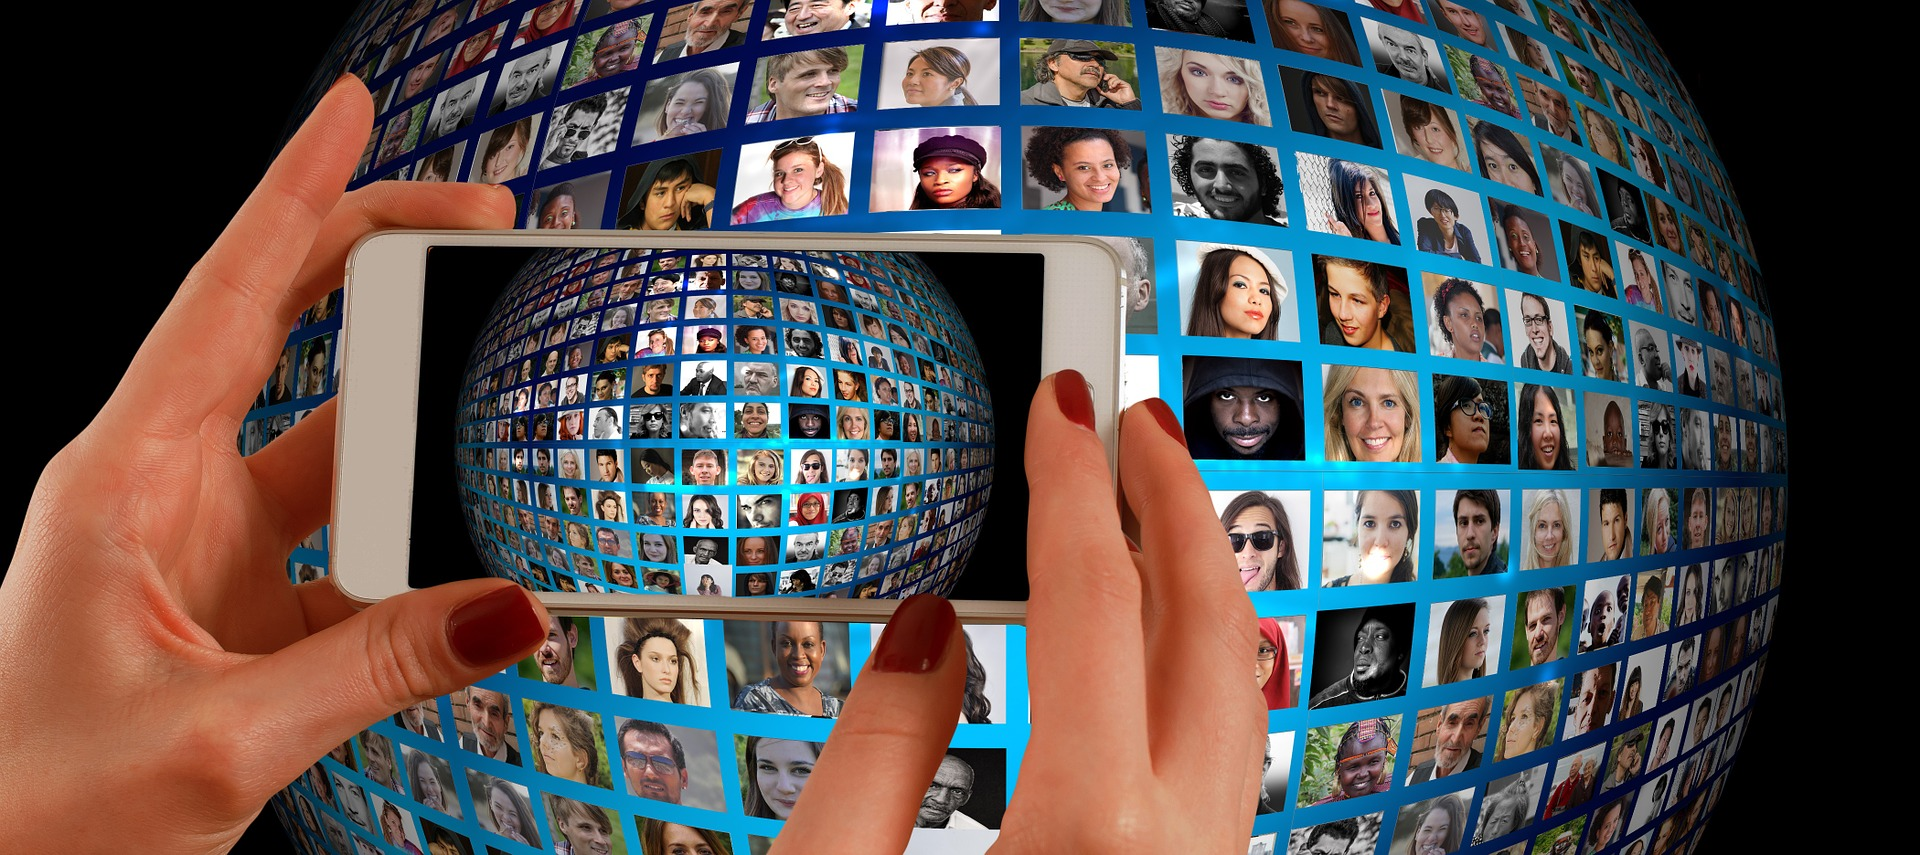

In [281]:
from IPython.display import Image
from IPython.core.display import HTML
path = '/Users/admin/Documents/smartphone.jpg'
Image(filename = path, width=600, height=300)

# I. Background 

### The Russian Language
Russian is a native language for 154 million people. Approximately 265 million people speak it around the world. Russian is spoken not only in the Russian Federation but also has historical roots in the following countries:
 - Armenia, Azerbaijan, Belarus, Estonia, Georgia, Israel, Kazakhstan, Kyrgyzstan, Latvia, Lithuania, Moldova, Poland, Tajikistan, Turkestan, Ukraine, and Uzbekistan.   

<sub>"How many people around the world speak Russian," *Russia Beyond*, accessed October 23, 2018,https://www.rbth.com/lifestyle/328250-how-many-people-speak-russian.

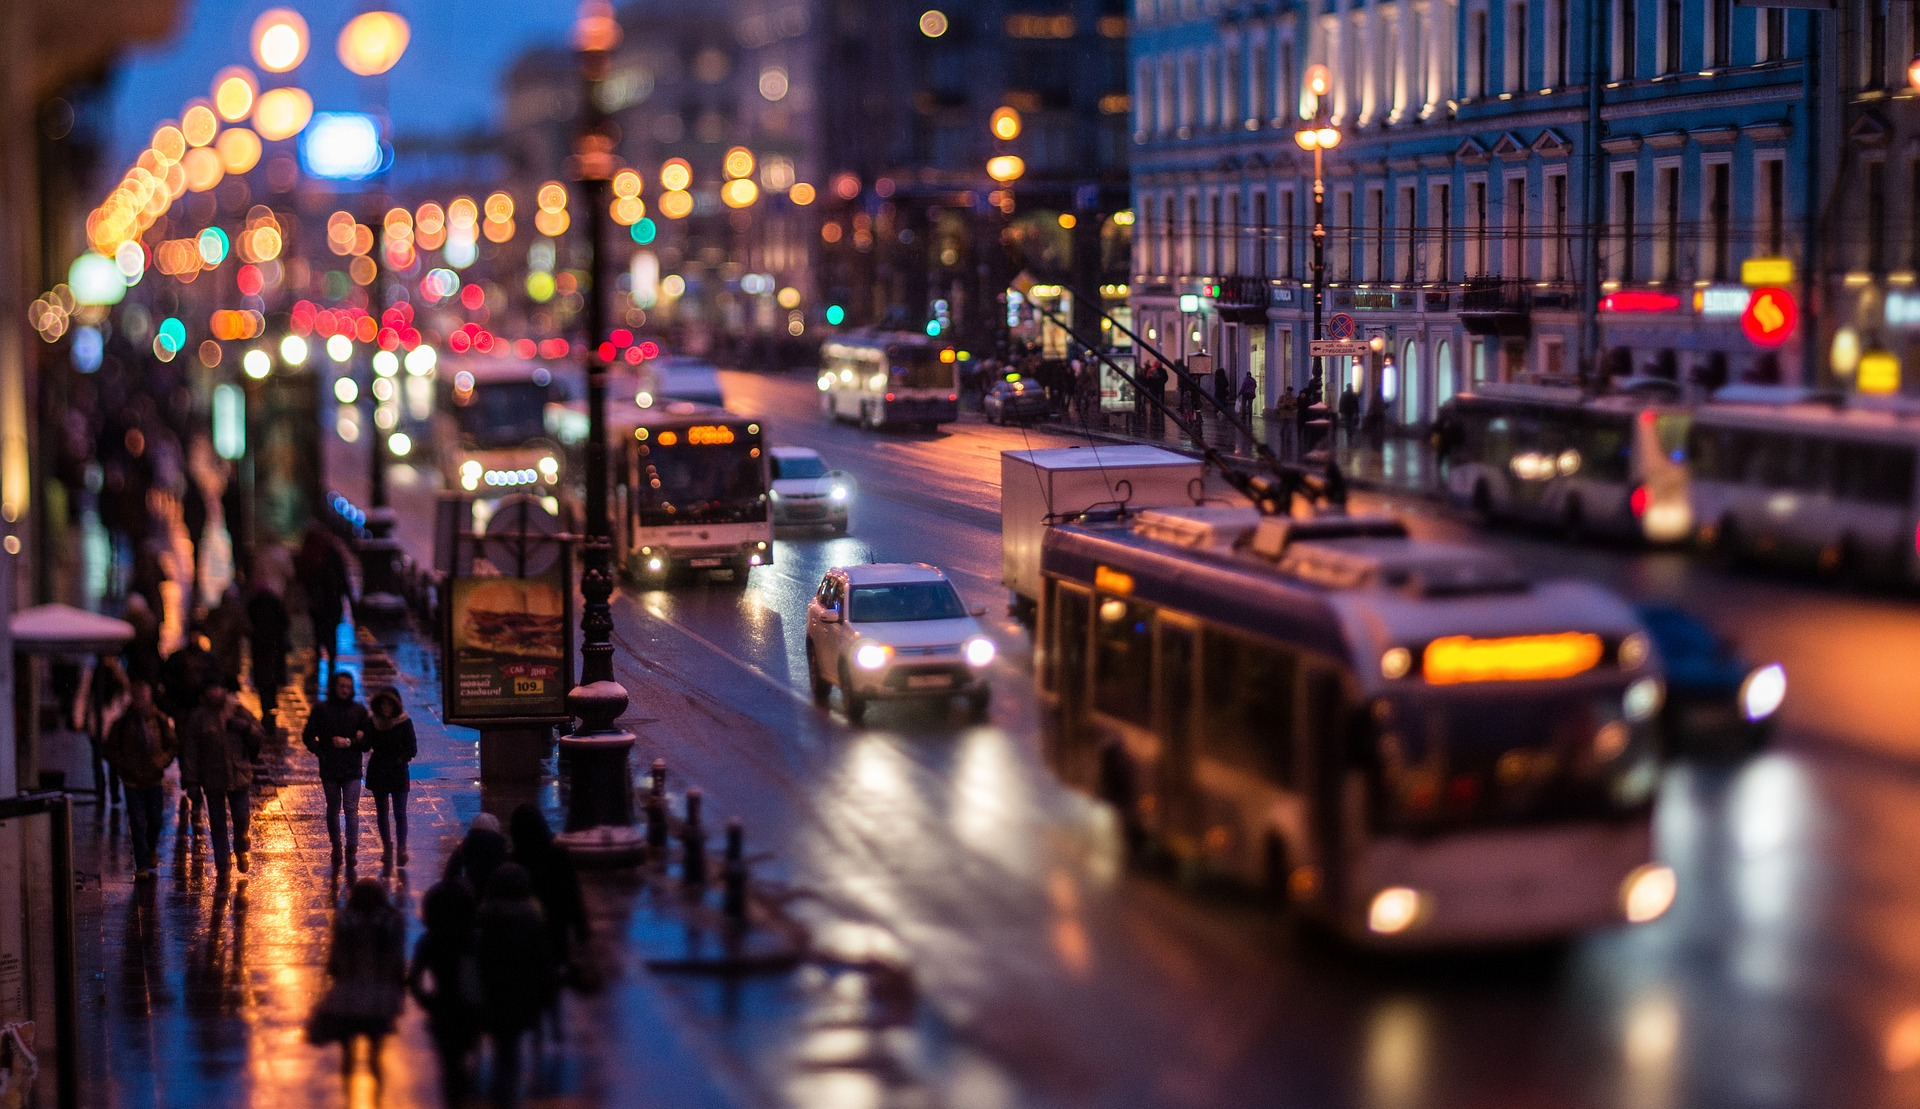

In [282]:
path = '/Users/admin/Documents/view.jpg'
Image(filename = path, width=600, height=300)

### Why Turn To Online Advertisement?

As of 2016, in Russia alone, advertisement market, reached 5.49 billion dollars. The fastest growing advertisement type was online advertisement: online ads revenue grew by 21% and reached 2.08 billion dollars. So, since the market is expanding, why not innovate? 

<sub>"Rynok reklamy v Rossii vyros do rekordnogo urovniia s 2000 goda," *RBK*, 
 accessed October 23, 2018, https://www.rbc.ru/technology_and_media/21/03/2017/58cfddda9a7947de08281065.


### What Value Can We Add?

Currently, humans write ads themselves, however, this genre has many "go-to" clichés. Therefore, it could be worthwhile to create a product that helps people save time by automating the process of ad creation. In this project, I explore some possible solutions to this challenge:

    1) Models that suggest appropriate ad texts /ad titles from the existing database of texts and titles
    2) First experimental work towards generating ads texts from scratch: 
https://github.com/innawendell/Final_Capstone/blob/master/Ads_Generator_Experiment.ipynb

This notebook contains my attempts to accomplish the first task of suggesting relevant ad titles that are relevant from the existing list. To tackle this problem, I take two approaches:

    1) Unsupervised Learning Model (using cosine similarity scores)
    2) Supervised Learning Models:
       a) Logistic Regression
       b) Random Forest
       c) XGBoost
       d) Recurrent Neural Network
 
 On a final note, do not get discouraged if you don't speak Russian. While the project was based on Russian ads, the solutions and the pipeline are universal (could be used for any language). In my case, Russian introduced an extra level of complexity due to its convoluted grammatical system.

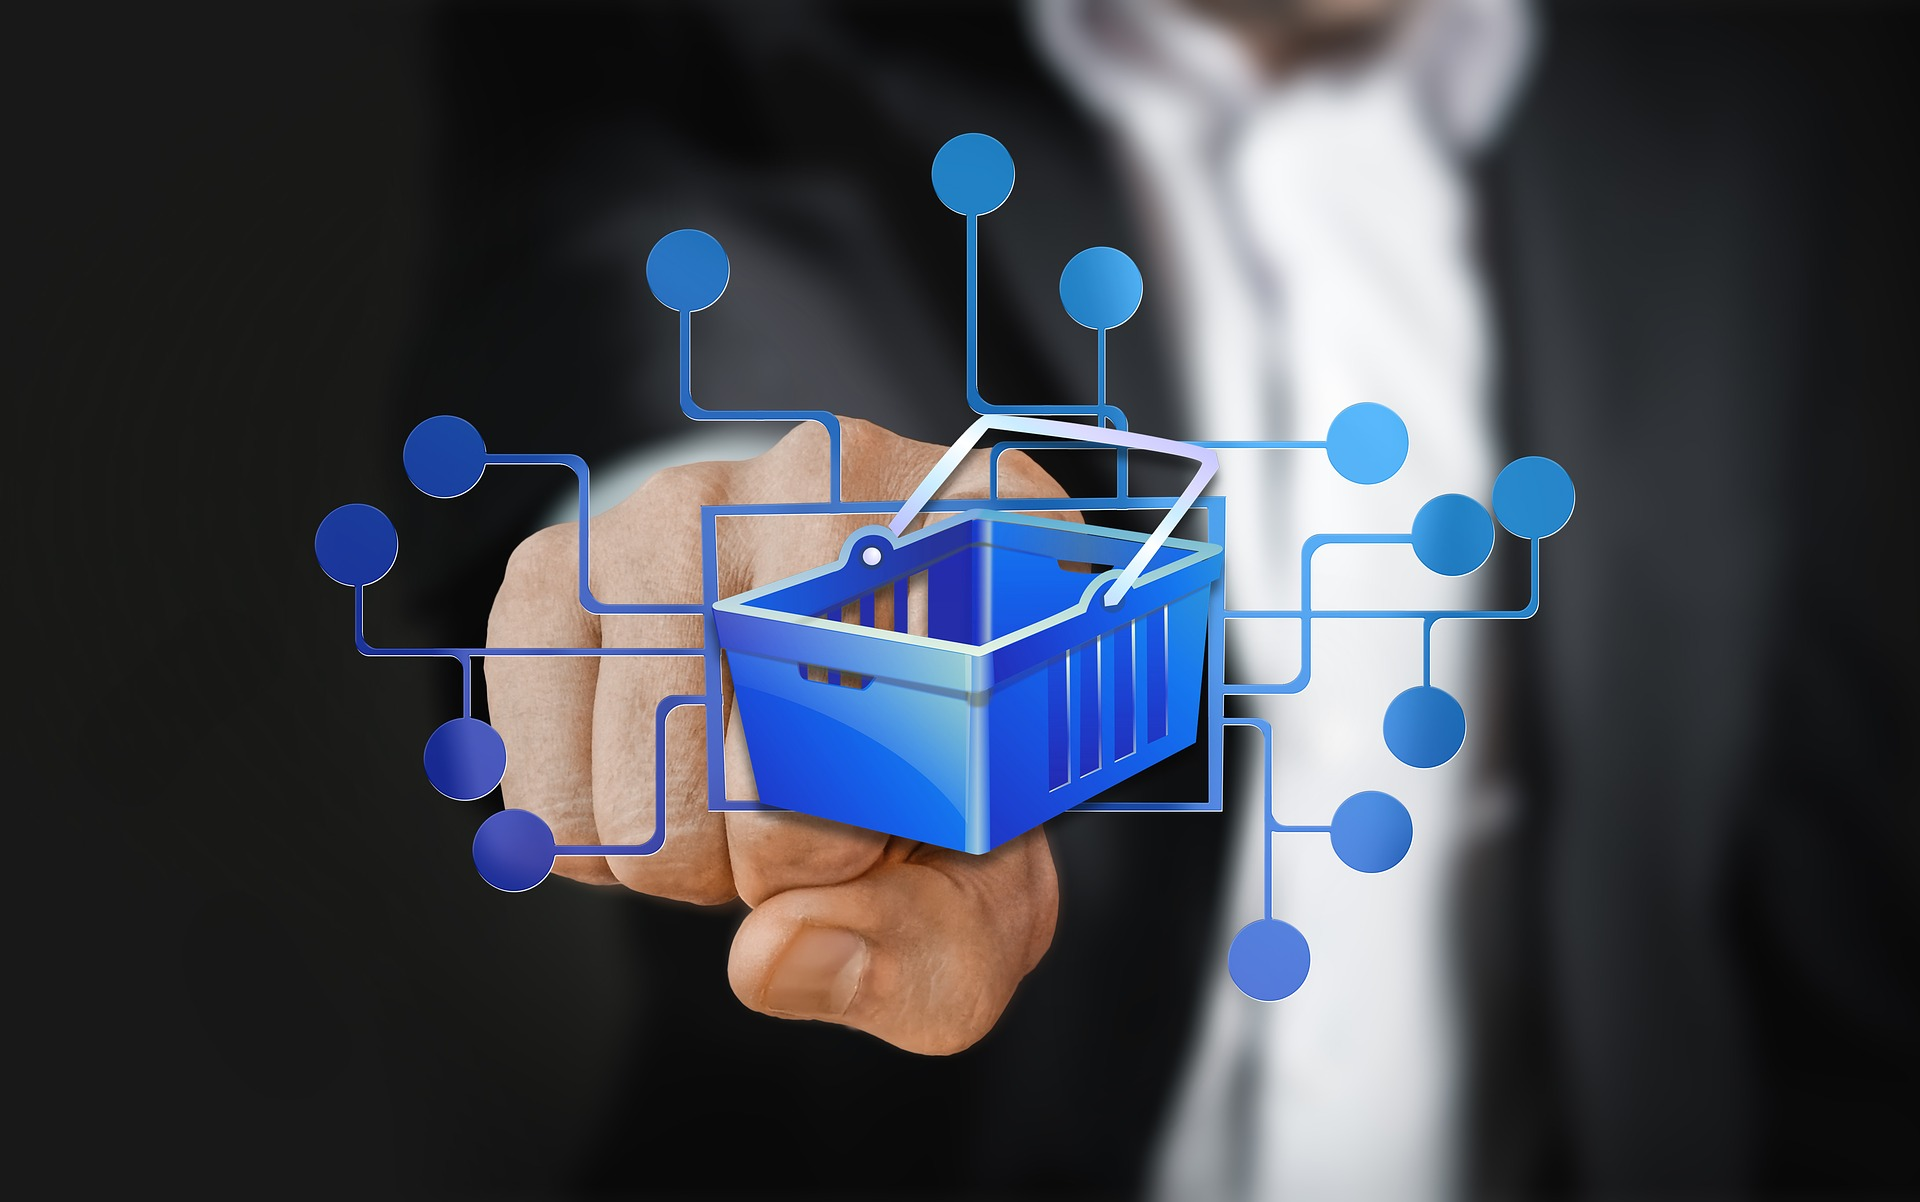

In [283]:
path = '/Users/admin/Documents/Automation.jpg'
Image(filename = path, width=600, height=300)

In [230]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

# II. Data Source and Data Preprocessing

The data set that I used for this project comes from Russia, Ukraine, Belarus, and Kazakhstan and was collected from October 2016 to January 2017. It includes ads for a vast variety of products (ranging from electronics to purses). The dataset came to my possession from a public source: https://www.kaggle.com/kotobotov/context-advertising, however, my interest in the subject was prompted by my previous work experience as an Ads Quality Rater (for Russian and English).

In [2]:
# load the dataset
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

At this point, it looks like we have a rather large dataset (nearly 800 000 entries), coming from almost 20 000 different ad domains. However, further investigation of the data shows an interesting fact: we have a lot of **duplicates** of different kinds: duplicate texts, duplicate titles, and completely identical rows. We do some cleaning...

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
ads.nunique()

atitle     571923
atext      350006
adomain     19181
dtype: int64

In [6]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [7]:
# delete the duplicate ad texts
unique_adstext =ads.drop_duplicates(subset = ['atext'], keep=False)

In [8]:
unique_adstext.nunique()

atitle     234515
atext      323003
adomain      4838
dtype: int64

In [9]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

234515

In [10]:
# drop duplicate titles
unique =unique_adstext.drop_duplicates(subset = ['atitle'], keep=False)

In [11]:
unique.nunique()

atitle     204601
atext      204601
adomain      4589
dtype: int64

In [12]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204601 entries, 0 to 772521
Data columns (total 3 columns):
atitle     204601 non-null object
atext      204601 non-null object
adomain    204601 non-null object
dtypes: object(3)
memory usage: 6.2+ MB


In [13]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [14]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [15]:
type(unique['atext'])

pandas.core.series.Series

Even after we do some initial cleaning, our data still requires a lot of work: it is not lemmatized (which would inflate the size of our vocabulary), the entries are capitalized, and there is punctuation. Let's address all these issues on step at a time. First, we will **remote the punctuation.** In this case, out of curiousity, I decided to keep the percentage signs because I was interested to see the trends associated with discounts.

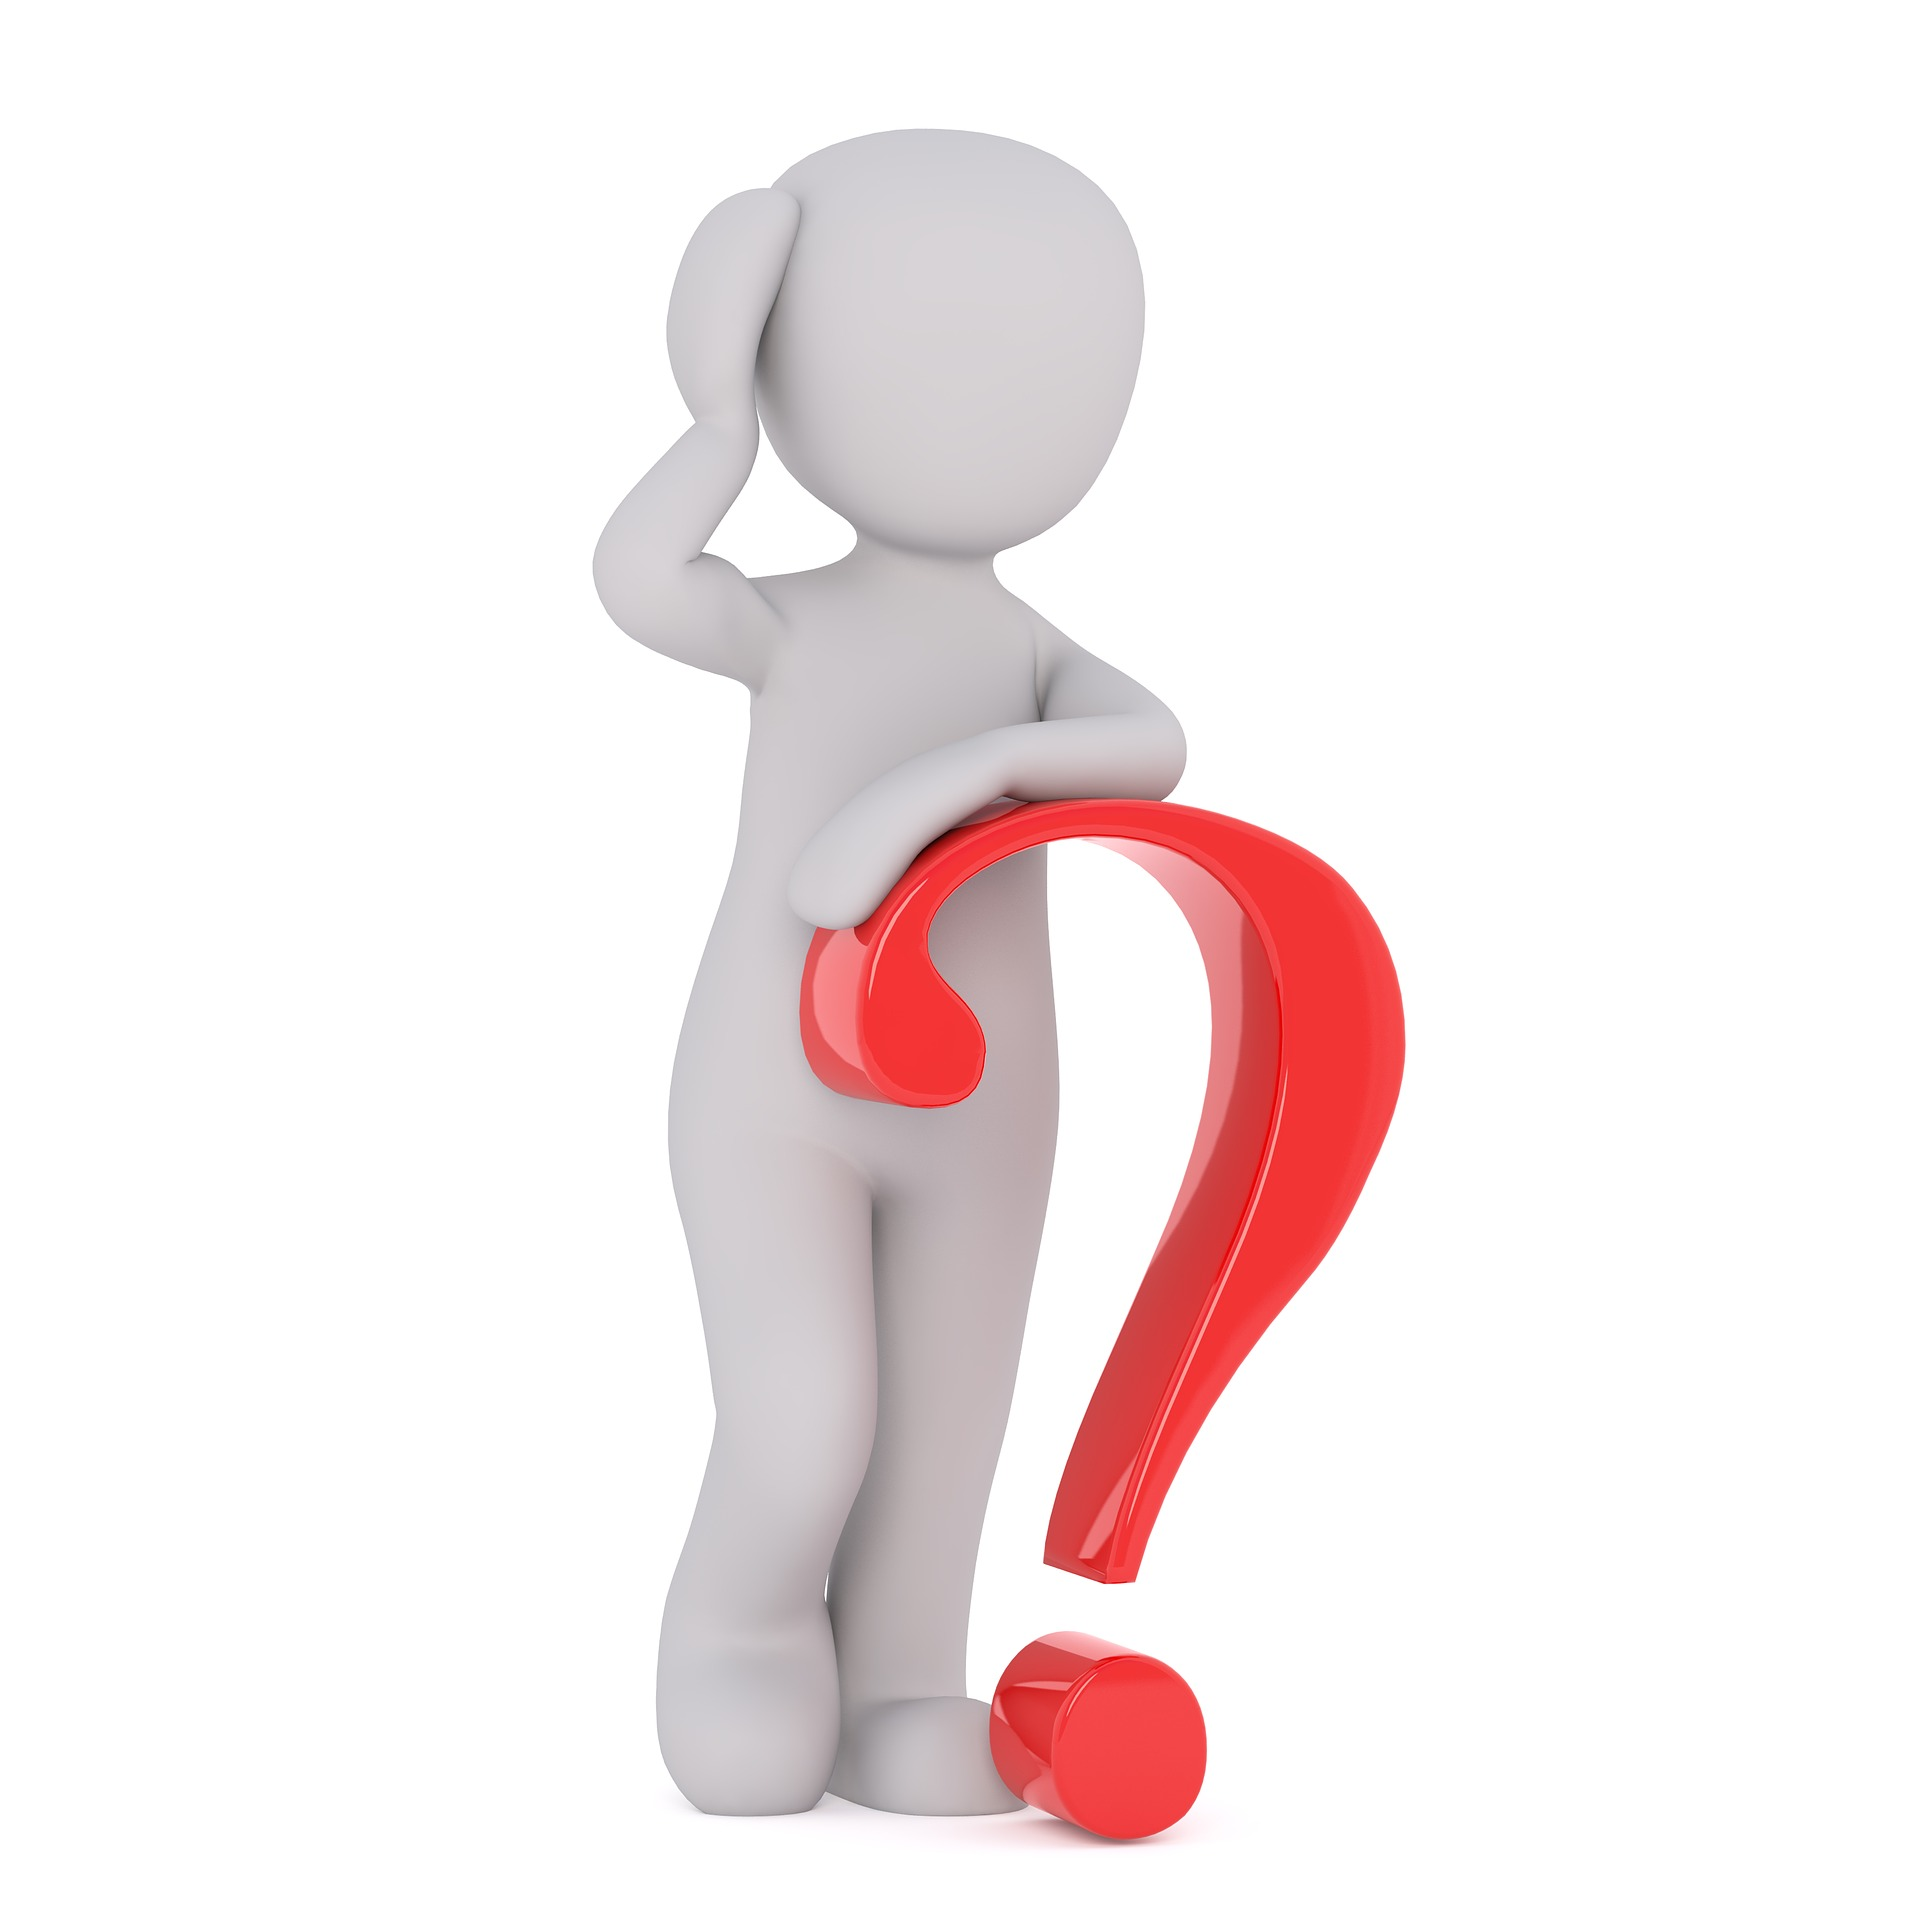

In [284]:
path = '/Users/admin/Documents/punctuation.jpg'
Image(filename = path, width=600, height=300)

In [16]:
#remove punctuation from the entires
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [17]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [18]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

In [19]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

In [20]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [21]:
unique['atext'].iloc[0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [22]:
unique = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [23]:
unique = unique.drop_duplicates(subset = ['atext'], keep=False)

In [24]:
unique.nunique()

atitle     200718
atext      200718
adomain      4534
dtype: int64

Now comes the moment of truth: will the python wrapper for Yandex's Mystem lemmatizer actually work? By the way, here is the link to pymystem3 if you are interested: https://pypi.org/project/pymystem3/. Big appreciation and many thanks to Denis Sukhonin and Alexander Panchenko who created the wrapper: it gets the job done.

In [25]:
# lemmatization with mystem

m = Mystem()
def text_parser(series): 
    series_copy = series.copy()
    list_of_strings = []

    for row in series:
        ad_string = ''
        lemmas = m.lemmatize(row)
        for count, lemma in enumerate(lemmas):
            if (lemma !=  ' ' and lemma != '\n' and count < len(lemmas)):
                ad_string += lemma +' '
        # .lower() helps change foreign words (in Latin script) to lower case 
        #(Russian lemmas are returned in lower case)
        list_of_strings.append(ad_string.lower())
    return list_of_strings

In [26]:
#lemmatization of the titles
unique_lem = unique.copy()
unique_lem['atitle'] = text_parser(unique['atitle'])

In [27]:
#lemmatization of the texts
unique_lem['atext'] = text_parser(unique['atext'])

In [28]:
unique_lem.head()

,atitle,atext,adomain
0,клуб активный отдых 0 67,детский пейнтбол спортивный пейнтбол тактическ...,0-67.relax.by
1,антигравитационный чехол iphone 5,успевать купить антигравитационный чехол для i...,0-antigravity.ru
3,беспроцентный заем от moneyveo,без справка получать до 3 000 грн на карта под...,0-credit.moneyveo.ua
4,беспроцентный заем сотрудник,акция получать кредит онлайн под 0 % без спр...,0-credit.moneyveo.ua
11,аnti gravity case,аnti gravity case – уникальный антигравитаци...,0-gravity.online-shop-2017.ru


In [29]:
unique_lem.shape

(200718, 3)

At this point, our punctuation removal and lemmatization is complete. Sounds like the perfect time to remove some more duplicates (close to 10 000 more)!

In [30]:
# remove duplicate titles
unique_lem = unique_lem.drop_duplicates(subset = ['atitle'], keep=False)

In [31]:
#remove duplicate texts
unique_lem = unique_lem.drop_duplicates(subset = ['atext'], keep=False)

In [32]:
# remove duplicate rows
unique_lem = unique_lem.drop_duplicates(keep=False)

In [33]:
unique_lem.shape

(191257, 3)

In [34]:
unique_lem.nunique()

atitle     191257
atext      191257
adomain      4479
dtype: int64

In [35]:
unique_lem.nunique()

atitle     191257
atext      191257
adomain      4479
dtype: int64

In [36]:
unique_lem.shape

(191257, 3)

In [37]:
#verfiy that we indeed have no duplicates
len(set(unique_lem['atext']))

191257

In [38]:
#verfiy that we indeed have no duplicates
len(set(unique_lem['atitle']))

191257

We investigate our data further and fortunately find out that we have no missing entries.

In [39]:
#check the data to see if we have any missing values
unique_lem.isnull().sum()

atitle     0
atext      0
adomain    0
dtype: int64

Currently, we are dealing with strings, however, for modelling purposes, we need to convert our rows into lists of strings. An easy way to do it is to use `.split()`

In [40]:
# from strings to lists of strings
unique_lem['atitle'] = unique_lem['atitle'].apply(lambda x: x.split())

In [41]:
# from strings to lists of strings
unique_lem['atext'] = unique_lem['atext'].apply(lambda x: x.split())

# Creation of Training / Test Sets 

At this point in time, we split our dataset into the training and test sets. From the titles that we have available, we will try to find the best matching titles for our ad texts.

In [42]:
X = unique_lem['atext']
y = unique_lem['atitle']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [44]:
X_test.head()

538096          [bosch, smv, 65m30, от, 1642, 84, доставка]
482436    [быть, в, наличие, плиткорез, на, монорельс, 6...
371034    [купить, баня, из, брус, под, ключ, высокий, к...
201971    [купить, thrustmaster, джойстик, thrustmaster,...
599930    [свитшот, в, интернет, магазин, 3d, футболка, ...
Name: atext, dtype: object

In [45]:
merged_list = X_train + y_train

Since we cannot feed unprocessed text to machine learning models, we will train a Word2Vec model to create word vectors. Word2vec model creates word vectors by making more similar word vectors for the words that frequently occur together in texts (share context) and by making less similar word vectors for the words that do not share the context (rarely occur together in texts). 

# III. Training Word2Vec Model

In [46]:
model = word2vec.Word2Vec(
    merged_list,
    workers=4,   #tried to experiment by setting it to '-1': the results were faster but completely meaningless  
    min_count=5,   
    window=50,      
    sg=0, #use CBOW         
    sample=1e-4,  
    size=300,      
    hs=1           
)


Our Word2Vec model has close to 20,000 unique vocabulary items (or lemmas) since we made a conscious choice to lemmatize the texts in order to reduce the size of the vocabulary.

In [47]:
vocab = model.wv.vocab.keys()
print(len(vocab))

19849


A good way to gain insight into our word vector space is to do a `t-SNE` plot which allows us to visualize word vectors in a reduced 2-dimensional space. This visualization can be used to `check` if our Word2Vec model makes sense. It looks like our model is doing fine: it placed 'washing' close to 'machine' and close to 'refrigerator', it learned that 'lenovo', 'asus', 'dell,' and 'laptops'frequently occur in similar contexts. In fact, it was this very plot that helped me figure out that my Word2Vec model was not producing meaningful results when I changed parameter 'workers' to '-1' but parallelisation produced poor results.

In [48]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 1000:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title('t-SNE Plot of the Word2Vec Model', fontsize=20)
    plt.show()

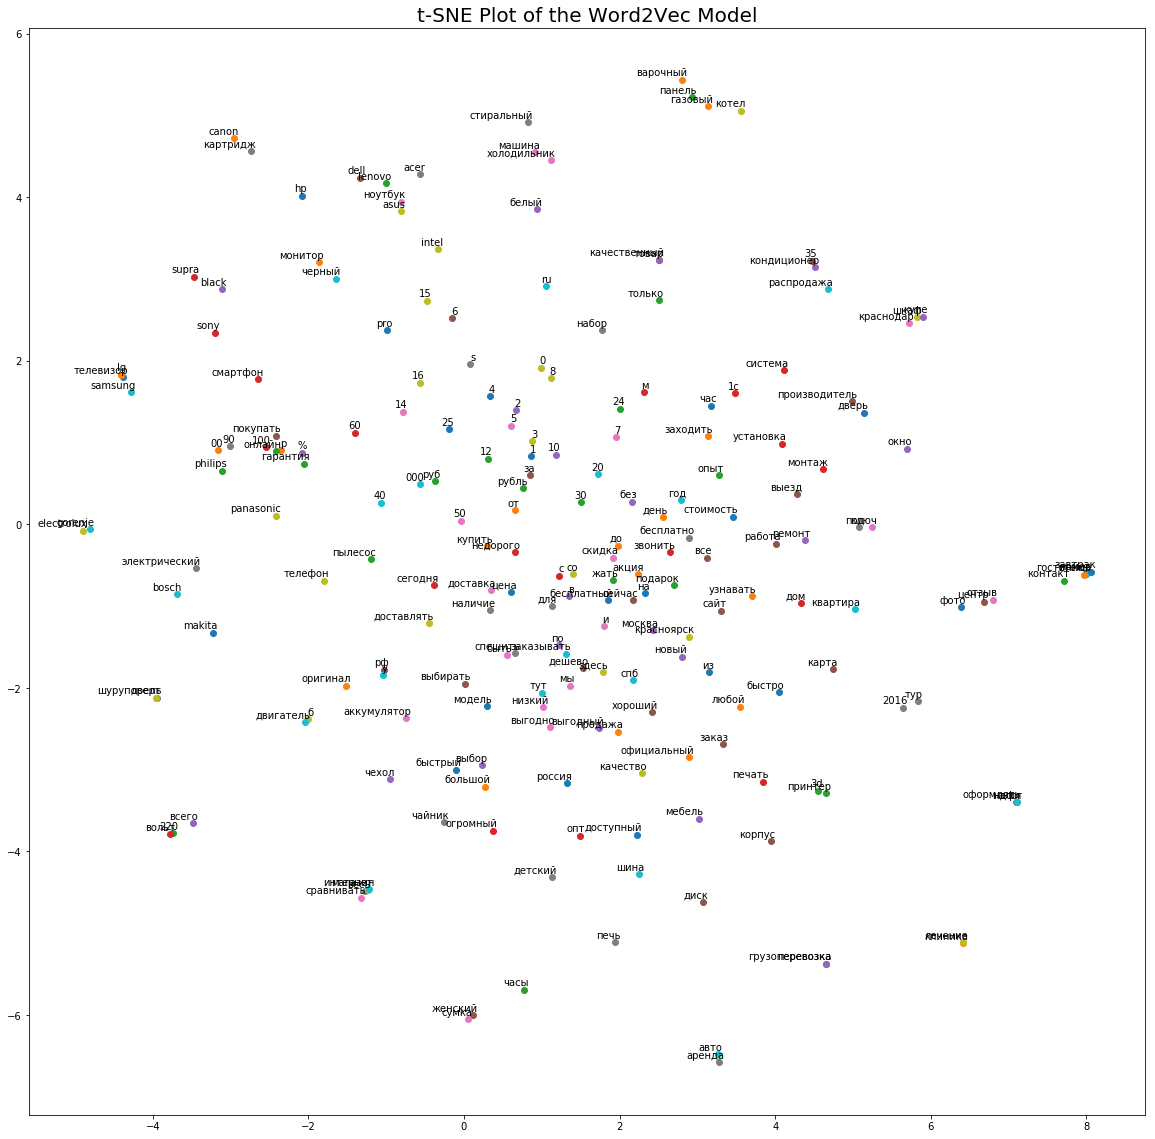

In [49]:
tsne_plot(model)

# IV. Unsupervised Solution

### Ranking

Now, it is time for us to explore how well can predict best matching ad titles using unsupervised learning techniques, namely, cosine similarity scores.

For computation reasons, we will take a random sample of 1000 examples. We will convert each ad text and each ad title into document vectors and calculate cosine similarity scores for each ad text with 1000 potential ad titles. Then, we will compute the rank of the correct title. This procedure, we will repeat for each ad text in our sample. Eventually, we will be able to compute the `mean rank of the correct title` and the `percentage of the correct titles in the top three results`. This will give us a way to evaluate our unsupervised solution.

In [50]:
test_df = pd.DataFrame(X_test)

In [51]:
test_df['atitle'] = y_test

In [52]:
test_df.shape

(57378, 2)

In [53]:
test_df.head()

,atext,atitle
538096,"[bosch, smv, 65m30, от, 1642, 84, доставка]","[bosch, smv, 65m30]"
482436,"[быть, в, наличие, плиткорез, на, монорельс, 6...","[плиткорез, на, монорельс, 600, мм]"
371034,"[купить, баня, из, брус, под, ключ, высокий, к...","[купить, баня, из, брус, под, ключ]"
201971,"[купить, thrustmaster, джойстик, thrustmaster,...","[thrustmaster, hotas, warthog, 296072]"
599930,"[свитшот, в, интернет, магазин, 3d, футболка, ...","[свитшот, в, интернет, магазин]"


In [54]:
sample_test_df_checking = test_df.sample(1000, random_state=0)

In [55]:
sample_test_df_checking = sample_test_df_checking.reset_index(drop=True)

In [56]:
sample_test_df_checking.head()

,atext,atitle
0,"[печь, теплодар, топ, купить, здесь, хороший, ...","[печь, теплодар, топ, купить, здесь]"
1,"[покупать, origin, и, др, аккаунт, по, низкий,...","[магазин, игровой, аккаунт, origin]"
2,"[обновлять, навигатор, garmin, nuvi, жать]","[обновлять, навигатор, garmin, nuvi]"
3,"[полукомбинезон, crockid, сравнивать, цена, ве...","[полукомбинезон, crockid]"
4,"[декоративный, зеркало, сравнивать, цена, весь...","[декоративный, зеркало]"


In [57]:
from sklearn.preprocessing import normalize

def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [58]:
sample_text_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 0])
    if vector is not None:  
        sample_text_vectors_test.append(vector[0])
    # append 'M' for 'missing' if all words in the text are missing in our vocabulary
    else:
        sample_text_vectors_test.append('M')

In [59]:
sample_title_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 1])
    if vector is not None:  
        sample_title_vectors_test.append(vector[0])
    else:
        sample_title_vectors_test.append('M')

In [60]:
test_sample_vectorized = sample_test_df_checking.copy()
test_sample_vectorized['text vectors'] = sample_text_vectors_test
test_sample_vectorized['title vectors'] = sample_title_vectors_test

In [61]:
test_sample_vectorized.head()

,atext,atitle,text vectors,title vectors
0,"[печь, теплодар, топ, купить, здесь, хороший, ...","[печь, теплодар, топ, купить, здесь]","[-0.1004421405889524, -0.016625501758555625, 0...","[-0.07476625751117451, -0.015666646538860112, ..."
1,"[покупать, origin, и, др, аккаунт, по, низкий,...","[магазин, игровой, аккаунт, origin]","[-0.08387900924497771, 0.020546374205926612, 0...","[-0.05370330718723652, -0.09463371673059931, 0..."
2,"[обновлять, навигатор, garmin, nuvi, жать]","[обновлять, навигатор, garmin, nuvi]","[-0.08809165606923602, 0.055781733675248815, 0...","[-0.079955876751148, 0.05571725238277637, 0.03..."
3,"[полукомбинезон, crockid, сравнивать, цена, ве...","[полукомбинезон, crockid]","[0.04773514817883415, -0.019786427077676937, -...","[0.04377184706714088, 0.07724336370065593, -0...."
4,"[декоративный, зеркало, сравнивать, цена, весь...","[декоративный, зеркало]","[0.011403538714006897, -0.022299360407702504, ...","[-0.04932084641903472, 0.02945866564080509, -0..."


In [62]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        sim_score = cosine_similarity(vector_one.reshape(1, -1), each.reshape(1, -1))
        cosines.extend(sim_score) 
    return cosines

In [63]:
sample_test_df_checking.iloc[0, :]

atext     [печь, теплодар, топ, купить, здесь, хороший, ...
atitle                 [печь, теплодар, топ, купить, здесь]
Name: 0, dtype: object

In [64]:
def rank_checker(df, number):
    cosines_results = cosine_calculator(df.iloc[number, 2], df.iloc[:, 3])
    series = pd.Series(cosines_results, index =df.index)
    
    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [65]:
cosine_similarity(test_sample_vectorized.iloc[2, 2].reshape(1, -1), test_sample_vectorized.iloc[2, 3].reshape(1, -1))

array([[0.98877595]])

In [66]:
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['text vectors'] != 'M']
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['title vectors'] != 'M']

In [67]:
ranks = []
for row in range(len(test_sample_vectorized)):
    rank = rank_checker(test_sample_vectorized, row)
    ranks.append(rank)

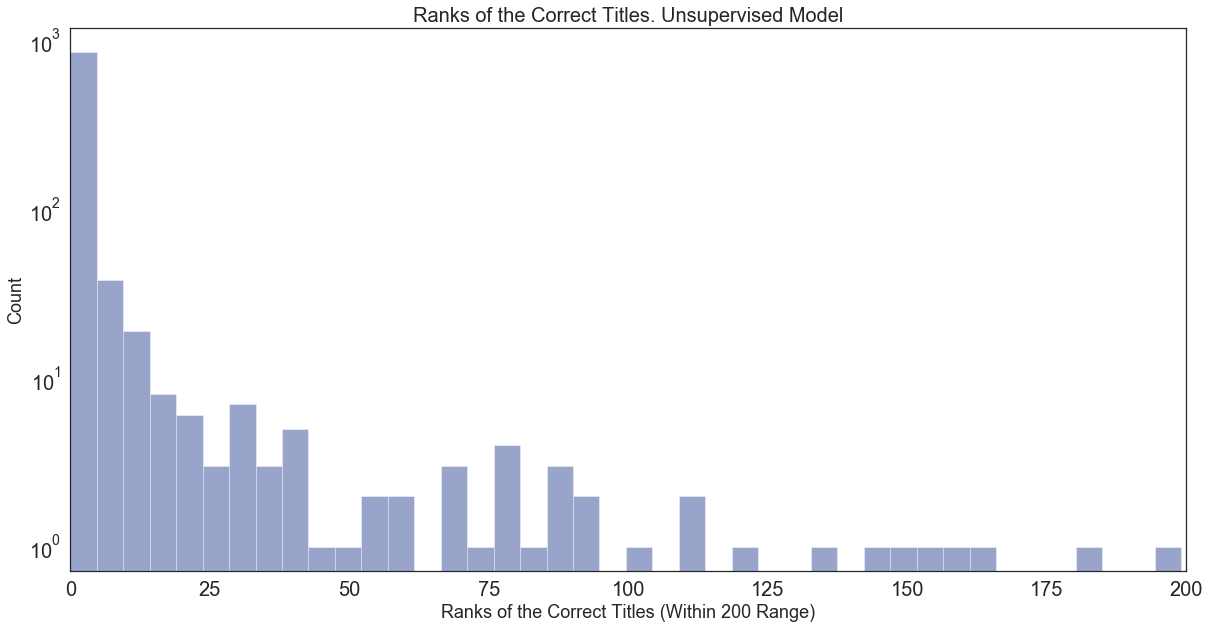

In [131]:
plt.figure(figsize=(20, 10))

sns.set(style="white", palette="dark", color_codes=True)
ax = sns.distplot([rank for rank in ranks], bins =200, kde=False) 
ax.set_yscale('log', basey=10)
plt.xlim(0,200)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Ranks of the Correct Titles (Within 200 Range)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Ranks of the Correct Titles. Unsupervised Model', fontsize=20)

plt.show()

In [69]:
small = []
for rank in ranks:
    if rank <=3:
        small.append(rank)   
        
print('Mean Rank: ', np.mean(ranks))    
print('Proportion of the Correct Titles In The Top Three Results: ', len(small) / len(ranks)) 

Mean Rank:  16.956740442655935
Proportion of the Correct Titles In The Top Three Results:  0.8420523138832998


Our unsupervised model produces pretty good results: the mean rank of the correct title is `16.96`, whereas the proportion of the correct titles in the top three recommended results is `0.84`. However, we try to solve the same problem with supervised models and see if we can do better. Additional benefits of a supervised solution will include our ability to calculate probability that an ad text and an ad title are a match.

# V. Supervised Solution

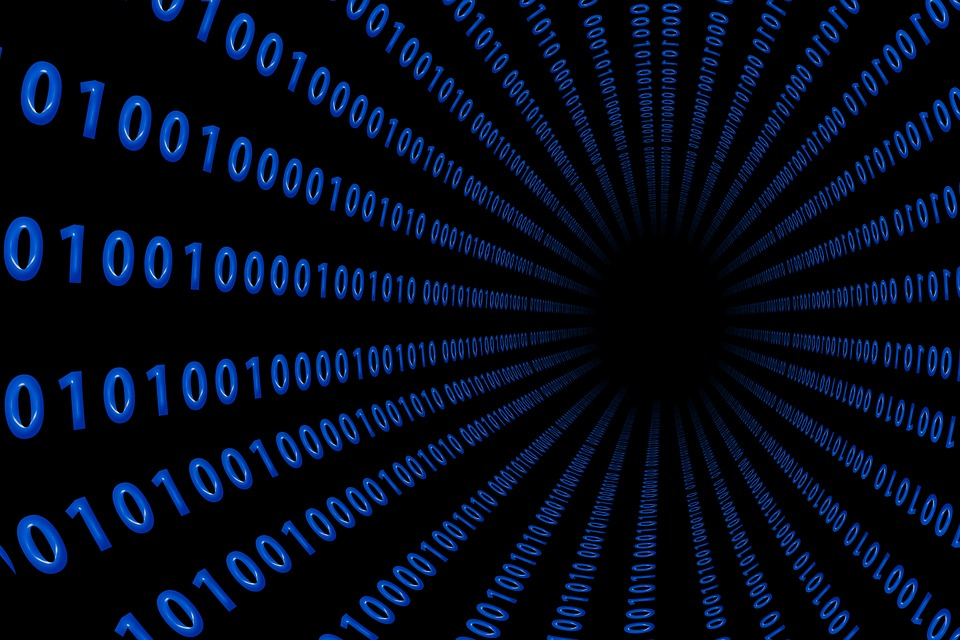

In [285]:
path = '/Users/admin/Documents/01.jpg'
Image(filename = path, width=600, height=300)

The challenge of implementing a supervised solution lies in the fact that we have hundreds of thousands of outcomes (i.e. potential titles). We will, however, approach this problem from a different angle. We will create a training set that will have `50% of correct (matching) ad text - ad title pairs and 50% of incorrect (“shuffled) pairs`. Afterwards, we will convert our texts and titles into document vectors and concatenate them: once again, half of our concatenated vectors will be matching and the other half will be ‘mismatched.’ Then we will simply train a binary classifier: our matched or mismatched concatenated vectors will be the input and `class 0 or 1` (pair or not pair) will be target outcome. With 0/1 class prediction, we will also get probabilities of a concatenated vector being a pair (1) which we will later on use for evaluation.


## 1. Training Set Preparation

In [70]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train 
training_df['title vectors'] = y_train

In [71]:
X_train.head()

157245    [цена, от, 450, руб, сут, бронировать, хостеть...
54265                             [за, 1400, руб, доставка]
379999    [мобильный, телефон, keneksi, m2, 40, 25, р, г...
692639    [семя, колокольчик, сравнивать, цена, весь, ин...
44467     [купить, lenovo, смартфон, lenovo, a7000, a, b...
Name: atext, dtype: object

In [72]:
y_train.head()

157245           [дом, путешественник, ярославль]
54265                   [чайник, sinbo, sk, 7310]
379999                   [keneksi, m2, 40, 25, р]
692639                        [семя, колокольчик]
44467     [смартфон, lenovo, a7000, a, black, ds]
Name: atitle, dtype: object

In [73]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test
test_df['title vectors'] = y_test

In [74]:
test_df.head()

,text vectors,title vectors
538096,"[bosch, smv, 65m30, от, 1642, 84, доставка]","[bosch, smv, 65m30]"
482436,"[быть, в, наличие, плиткорез, на, монорельс, 6...","[плиткорез, на, монорельс, 600, мм]"
371034,"[купить, баня, из, брус, под, ключ, высокий, к...","[купить, баня, из, брус, под, ключ]"
201971,"[купить, thrustmaster, джойстик, thrustmaster,...","[thrustmaster, hotas, warthog, 296072]"
599930,"[свитшот, в, интернет, магазин, 3d, футболка, ...","[свитшот, в, интернет, магазин]"


In [75]:
training_df.shape

(133879, 2)

In [76]:
test_df.shape

(57378, 2)

In [77]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index=True)
    
    return concat_result

In [78]:
training_df_mixed = mixed_df_creator(training_df)

In [79]:
test_df_mixed = mixed_df_creator(test_df)

In [80]:
training_df_mixed.tail()

,text vectors,title vectors,pair class
133874,"[карнавальный, костюм, медведь, сравнивать, це...","[искать, акриловый, ванна, в, москва]",0
133875,"[построение, стена, в, 3d, max, обучать, мини,...","[портативный, акустика, philips]",0
133876,"[edifier, s2000, от, 556, 44, доставка]","[ванночка, для, нога]",0
133877,"[часы, longines, сравнивать, цена, весь, интер...","[закрывать, наушники]",0
133878,"[купить, intel, процессор, intel, core, i7, 39...","[купить, маленький, диван, на, кухня]",0


In [81]:
test_df_mixed.head()

,text vectors,title vectors,pair class
0,"[bosch, smv, 65m30, от, 1642, 84, доставка]","[bosch, smv, 65m30]",1
1,"[быть, в, наличие, плиткорез, на, монорельс, 6...","[плиткорез, на, монорельс, 600, мм]",1
2,"[купить, баня, из, брус, под, ключ, высокий, к...","[купить, баня, из, брус, под, ключ]",1
3,"[купить, thrustmaster, джойстик, thrustmaster,...","[thrustmaster, hotas, warthog, 296072]",1
4,"[свитшот, в, интернет, магазин, 3d, футболка, ...","[свитшот, в, интернет, магазин]",1


In [82]:
training_df_mixed.shape

(133879, 3)

In [83]:
len(result_vector(training_df_mixed.iloc[0, 0])[0])

300

In [84]:
# vectorization of the ads text
text_vectors = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors.append(vector[0])
    else:
        text_vectors.append('M')

In [85]:
training_df_mixed_vectorized = training_df_mixed.copy()

In [86]:
training_df_mixed_vectorized['text vectors'] = text_vectors

In [87]:
# vectorization of the ads text
text_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors_test.append(vector[0])
    else:
        text_vectors_test.append('M')

In [88]:
test_df_mixed_vectorized = test_df_mixed.copy()

In [89]:
test_df_mixed_vectorized['text vectors'] = text_vectors_test

In [90]:
# vectorization of the ads title
title_vectors_tr = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_tr.append(vector[0])
    else:
        title_vectors_tr.append('M')

In [91]:
training_df_mixed_vectorized['title vectors'] = title_vectors_tr

In [92]:
# vectorization of the ads title
title_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_test.append(vector[0])
    else:
        title_vectors_test.append('M')

In [93]:
test_df_mixed_vectorized['title vectors'] = title_vectors_test

In [94]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df_mixed_vectorized= training_df_mixed_vectorized[training_df_mixed_vectorized['text vectors'] != 'M']
training_df_mixed_vectorized = training_df_mixed_vectorized[training_df_mixed_vectorized['title vectors'] != 'M']

test_df_mixed_vectorized= test_df_mixed_vectorized[test_df_mixed_vectorized['text vectors'] != 'M']
test_df_mixed_vectorized = test_df_mixed_vectorized[test_df_mixed_vectorized['title vectors'] != 'M']

In [95]:
training_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[0.03005183694439329, 0.05536960146465257, -0....","[-0.043823289101532714, 0.03811378067346819, -...",1
1,"[0.012252162430537443, 0.02117361815056552, -0...","[-0.05600515767465784, 0.005649338967588559, -...",1
2,"[-0.10341970419188341, 0.094138883385131, 0.06...","[-0.06037046484866378, 0.10887871312163354, 0....",1
3,"[0.041182122418595306, -0.03311531883296938, 0...","[0.029359228985884975, -0.007677850925677127, ...",1
4,"[-0.056308023546200896, 0.03959484827325433, 0...","[-0.06281405419170694, 0.0501700451979038, 0.0...",1


In [96]:
test_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[-0.0696747781432048, 0.05308637508455865, -0....","[-0.065260516085915, 0.025090199688685408, -0....",1
1,"[-0.0313806991939084, 0.01745147824088196, -0....","[-0.03910246165442947, 0.047695227662495794, -...",1
2,"[-0.052538948391327486, 0.014851281519948245, ...","[-0.07011564953124043, 4.2743372337223743e-05,...",1
3,"[0.056698500195523575, -0.03615206298340677, 0...","[0.08845448595602211, -0.02420586047257942, 0....",1
4,"[-0.0014660207163306074, 0.056847219912643264,...","[0.023266447400240014, 0.015562477104814907, -...",1


In [97]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

# Cosine Consistency Check

It is important to validate that our training and test sets were created correctly (that the first half has matching pairs whereas the second half has mismatched pairs). One way to check this would be to compute the average cosine similarity scores for the first half and for the second half.

In [98]:
sim_score_one = training_df_mixed_vectorized.iloc[:66939].apply(cosine_between_rows, axis = 1)
sim_score_two = training_df_mixed_vectorized.iloc[66939:].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one))
print('Mean cosine similarity score: second half', np.mean(sim_score_two))

Mean cosine similarity score: first half [[0.77957413]]
Mean cosine similarity score: second half [[0.23529142]]


In [99]:
sim_score_one_test = test_df_mixed_vectorized.iloc[:28689].apply(cosine_between_rows, axis = 1)
sim_score_two_test = test_df_mixed_vectorized.iloc[28689:].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one_test))
print('Mean cosine similarity score: second half', np.mean(sim_score_two_test))

Mean cosine similarity score: first half [[0.77138401]]
Mean cosine similarity score: second half [[0.24023139]]


It looks like our training and test sets are good: the first half has consistently higher cosine similarity scores. 

In [100]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1


In [101]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [102]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1


In [103]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [104]:
def df_converter(df):
    resultant_lists = df['text vectors'].apply(list) + df['title vectors'].apply(list)
    
    #print length for checking the length of concatenated vectors
    print(len(resultant_lists.iloc[0]))
    
    arrays = np.array(list(resultant_lists))
    return arrays

In [105]:
all_training_vectors = df_converter(training_df_mixed_vectorized)

600


In [106]:
all_test_vectors = df_converter(test_df_mixed_vectorized)

600


In [107]:
new_y_training = training_df_mixed_vectorized['pair class']

In [108]:
new_y_test = test_df_mixed_vectorized['pair class']

## 2. PCA And Parameter Finetuning

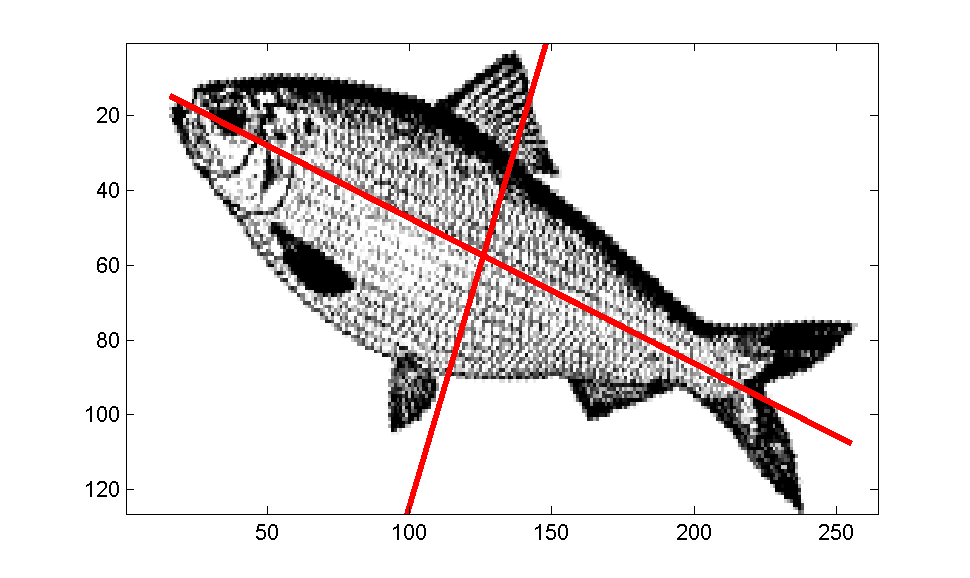

In [287]:
path = '/Users/admin/Documents/PCA_fish.png'
Image(filename = path, width=300, height=150)

Image by Lehalle, distributed under a CC-BY 2.0 license.

For computation reasons, we will reduce the dimensionality of our feature space from 600 to `150 principal components`. Additionally, we will take `a random sample of 10,000 examples` from our training set that we will use for `hyperparameter fine-tuning`.

In [109]:
sample_training_df = training_df_mixed_vectorized.sample(10000, random_state=0)

In [110]:
sample_training_df.head()

,text vectors,title vectors,pair class
100527,"[0.050592766223493055, -0.03977216685794399, 0...","[0.007558923037424434, 0.037450817613545115, -...",0
25083,"[-0.029611521239041514, -0.017895083241444693,...","[-0.08245601328722471, 0.021739509487895128, 0...",1
69955,"[-0.04601309435287612, 0.045906927051200266, 0...","[-0.04338888484913773, -0.036987628821233694, ...",0
71143,"[-0.006344811575446384, 0.028363638555981775, ...","[-0.10746910568333204, -0.007510683377160693, ...",0
118924,"[-0.021873848755476193, 0.02046631169395557, -...","[0.07804814482888388, 0.07849033468206058, 0.0...",0


In [111]:
from sklearn.decomposition import PCA


In [112]:
sample_training_arrays = df_converter(sample_training_df)

600


In [113]:
sample_y = sample_training_df['pair class']

In [114]:
pca_sample = PCA(n_components = 150)
X_train_sample_pca = pca_sample.fit_transform(sample_training_arrays)

In [115]:
X_train_sample_pca.shape

(10000, 150)

In [116]:
print(sum(pca_sample.explained_variance_ratio_))

0.8775083027481918


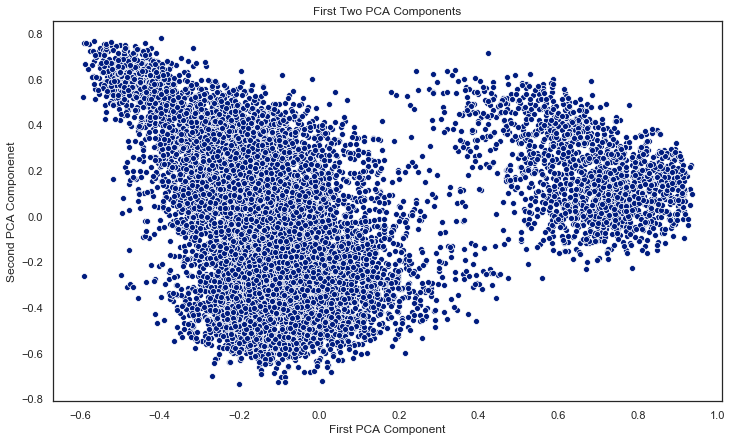

In [117]:
plt.figure(figsize=(12, 7))
plt.title('First Two PCA Components')
sns.scatterplot(X_train_sample_pca[:, 0], X_train_sample_pca[:, 1])
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Componenet')

plt.show()

There seems to be a clear separation in our data into two non-overlapping clusters.


## Thematic Clusters

In [309]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2, random_state=108)
y_pred_km = km.fit_predict(np.array(list(training_df_mixed_vectorized['text vectors'])))

In [320]:
model.most_similar(positive=[km.cluster_centers_[0]], topn=10)

[('интернет', 0.8690463304519653),
 ('сравнивать', 0.8665940761566162),
 ('магазин', 0.8423115611076355),
 ('весь', 0.8213285803794861),
 ('цена', 0.6042785048484802),
 ('джемпер', 0.5983591079711914),
 ('туфля', 0.5838765501976013),
 ('плащ', 0.5830694437026978),
 ('блузка', 0.5788583755493164),
 ('сапог', 0.5730682611465454)]

In [321]:
model.most_similar(positive=[km.cluster_centers_[1]], topn=10)

[('жать', 0.5802488327026367),
 ('шпонированный', 0.5642514228820801),
 ('заказывать', 0.5636888742446899),
 ('отсев', 0.5593673586845398),
 ('котельник', 0.5489376187324524),
 ('salter', 0.5458985567092896),
 ('алко', 0.5452987551689148),
 ('голодный', 0.543319582939148),
 ('подлежать', 0.535818338394165),
 ('иванов', 0.5315185785293579)]

In [322]:
km_test = KMeans(n_clusters = 2, random_state=108)
y_pred_km_test = km_test.fit_predict(np.array(list(test_df_mixed_vectorized['text vectors'])))

In [323]:
model.most_similar(positive=[km_test.cluster_centers_[0]], topn=10)

[('жать', 0.581786036491394),
 ('заказывать', 0.5659711360931396),
 ('шпонированный', 0.5655551552772522),
 ('отсев', 0.5602759718894958),
 ('котельник', 0.5484189391136169),
 ('salter', 0.5454184412956238),
 ('алко', 0.5450287461280823),
 ('голодный', 0.542309582233429),
 ('подлежать', 0.5351694226264954),
 ('на', 0.5320578813552856)]

In [324]:
model.most_similar(positive=[km_test.cluster_centers_[1]], topn=10)

[('интернет', 0.8691730499267578),
 ('сравнивать', 0.8672887682914734),
 ('магазин', 0.8426637053489685),
 ('весь', 0.8219060897827148),
 ('цена', 0.6045414805412292),
 ('джемпер', 0.5966088175773621),
 ('туфля', 0.5834953188896179),
 ('плащ', 0.5825386047363281),
 ('блузка', 0.5778844952583313),
 ('сапог', 0.5725820660591125)]

We can evaluate the two clusters produced by the KMeans clustering algorithm by finding the most similar word vectors. The returned most similar words remain consistent across the training set and test sets:one has cluster has mainly to do with the online clothes shopping and contains such words as `‘the internet’, ‘compare’, ‘store’, ‘price, ‘sweater, ‘shoe’, ‘coat’, ‘blouse,’ and ‘boots.’` The second cluster is less obvious but it consistently returns cluster centers that are similar to such words as `‘click’, ‘order’, ‘veneer’ (for furniture), ‘alco’, ‘hungry’, ‘riddling’, ‘salter’, and ‘be subjected to.’`

## 1. Logistic Regression

We will experiment with: 
- Logistic Regression
- Random Forest
- Xgboost
- Recurrent neural network 

The models range from the simplest to more complex. We will not use SVM because it is computationally costly. We will use GridSearchCV for hyperparameter finetuning.

In [118]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
    'penalty': ['l1', 'l2']}
]
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv =3,
                          scoring= 'accuracy', verbose=1)

grid_search.fit(X_train_sample_pca, sample_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [119]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.5087
Best parameters {'C': 1e-20, 'penalty': 'l1'}


## 2. Random Forest

In [120]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [5, 8, 12, 20, 30]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [5, 8, 12, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [121]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.8846
Best parameters {'max_depth': 30, 'n_estimators': 700}


In [122]:
param_grid_rfc = [
    {'n_estimators': [1000, 1200]
    }
]
rfc_one = RandomForestClassifier(n_jobs = -1, max_depth=30)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [1000, 1200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [123]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.8868
Best parameters {'n_estimators': 1200}


In [124]:
from xgboost import XGBClassifier

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8]
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [125]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9255
Best parameters {'max_depth': 8, 'n_estimators': 700}


In [127]:
param_grid_xgb_one = [
    {'n_estimators': [700, 1000],
    'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [700, 1000], 'learning_rate': [0.001, 0.5, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [128]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9281
Best parameters {'learning_rate': 0.1, 'n_estimators': 1000}


In [129]:
param_grid_xgb_two = [
    {'subsample': [0.25, 0.5, 1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8, n_estimators=1000, learning_rate=0.1, )

grid_search_xgb_two = GridSearchCV(xgb, param_grid_xgb_two, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_two.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'subsample': [0.25, 0.5, 1]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [130]:
print('Best score', grid_search_xgb_two.best_score_)
print('Best parameters', grid_search_xgb_two.best_params_)

Best score 0.9302
Best parameters {'subsample': 0.5}


### Training Set Summary:

Logistic Regression did not do better than random (0.5087) . One of the most plausible explanations for this is that the first assumption of any regression (existence of a linear relationship) does not hold here. XGBoost (accuracy of 0.9302) outperformed Random Forest (accuracy of 0.8868).

At this point, it was possible for us to use ‘accuracy’ for hyperparameter fine-tuning because we don’t have class imbalance. However, accuracy is not the only metric we use -  ranking is a much more valid option for final model evaluation.

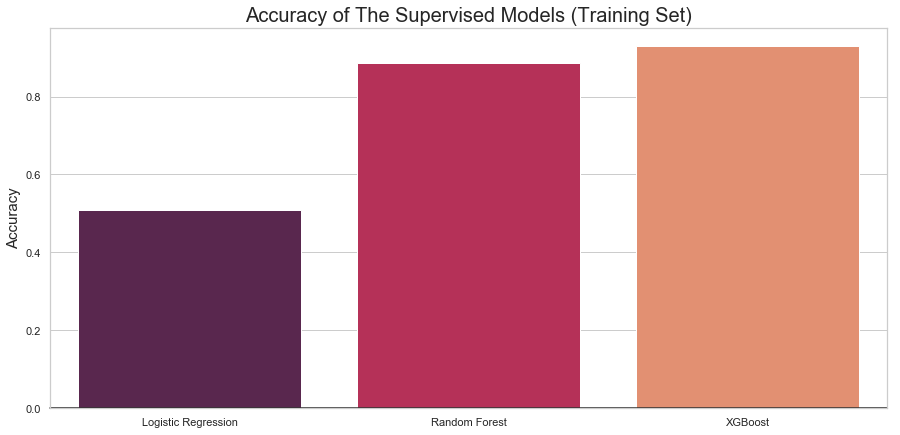

In [259]:
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
x = np.array(['Logistic Regression', 'Random Forest', 'XGBoost'])
y1 = np.array([0.5087, 0.8868, 0.9302])
ax1= sns.barplot(x=x, y=y1, palette="rocket")
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")
plt.title('Accuracy of The Supervised Models (Training Set)', fontsize=20)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

# VI. Test Set Evaluation

Now, it is time for us to evaluate the performance of our models of the test set. Here, we will use a variety of metrics, including: 
- accuracy
- precision (True Positives / (True Positives + False Positives)
- recall (True Positives / (True Positives + False Negatives)
- f1 scores (the ‘harmonic mean’ of the precision and recall (or 2 * (precision *recall) / (precision +recall).

However, we must admit that for this particular problem, these metrics might not be the best indicator of performance. Therefore, it became necessary to design a pipeline that would allow for ranking as a way to validate our models.


In [132]:
pca_testing = PCA(n_components = 150)
X_train_pca = pca_testing.fit_transform(all_training_vectors)
print(sum(pca_testing.explained_variance_ratio_))

X_test_pca = pca_testing.transform(all_test_vectors)

print(X_test_pca.shape)

0.8750967663119696
(57054, 150)


In [133]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

### Ranking

Our ranking pipeline is pretty similar to the ranking pipeline we used in the past for our unsupervised model evaluation. For computation reasons, we will use a random sample of 1000 examples. We will convert each ad text and each ad title into document vectors and then, instead of using cosine similarity scores, we will apply our pre-trained supervised models to compute probability of each ad text being a ‘match’ (correct pair, class 1) with 1000 potential ad titles. Then, we will compute the rank of the correct title. This procedure, we will repeat for each ad text in our sample. Once again, we will be able to compute the mean rank of the correct titles and the percentage of the correct titles in the top three results. This will allow to get a better and more objective idea of how well our supervised models are performing.


In [134]:
def probability_calculator(text_vector, title_vectors, model):
    list_concat_arrays = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        list_concat_arrays.append(resultant_array)
    
    made_array = np.array(list_concat_arrays)
    pca_transformed = pca_testing.transform(made_array)
    predictions = model.predict_proba(pca_transformed)[:, 1]
      
    return predictions

In [135]:
def rank_checker(df, number, model):
    probabilities = probability_calculator(df.iloc[number, 2], df.iloc[:, 3], model)
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [136]:
def ranks_evaluation(df, model):
    ranks = []
    for row in range(len(test_sample_vectorized)):     
        rank = rank_checker(test_sample_vectorized, row, model)
        ranks.append(rank)

    small = []
    for rank in ranks:
        if rank <=3:
            small.append(rank)   

    print(model) 
    print('Mean Rank: ', np.mean(ranks))    
    print('Proportion of the Correct Titles In The Top Three Results: ', len(small) / len(ranks)) 

    plt.figure(figsize=(20, 10))
    sns.set(style="white", palette="dark", color_codes=True)
    ax = sns.distplot(ranks, bins =200, kde=False) 
    ax.set_yscale('log', basey=10)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.xlim(0,200)
    plt.xlabel('Ranks Of The Correct Titles (Within 200 Range)', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.title('Ranks Of The Correct Title as Predicted By the Model', fontsize=20)
    
    plt.show()
    
    return ranks, small

## 1. Logistic Regression

In [137]:
lr_test = LogisticRegression(C= 1e-20, penalty= 'l1')

lr_test.fit(X_train_pca, new_y_training)

print('Accuracy:', lr_test.score(X_test_pca, new_y_test))

Accuracy: 0.5000175272548814


In [138]:
lr_pred = lr_test.predict(X_test_pca)

In [139]:
np.unique(lr_pred, return_counts=True)

(array([0]), array([57054]))

In [140]:
confusion_matrix(new_y_test, lr_pred )

array([[28528,     0],
       [28526,     0]])

In [141]:
print('F1 Score:', f1_score(new_y_test, lr_pred ))

F1 Score: 0.0


In [142]:
print('Recall score:', recall_score(new_y_test, lr_pred ))

Recall score: 0.0


In [143]:
print('Precision score:', precision_score(new_y_test, lr_pred ))

Precision score: 0.0


LogisticRegression(C=1e-20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Mean Rank:  496.5
Proportion of the Correct Titles In The Top Three Results:  0.004024144869215292


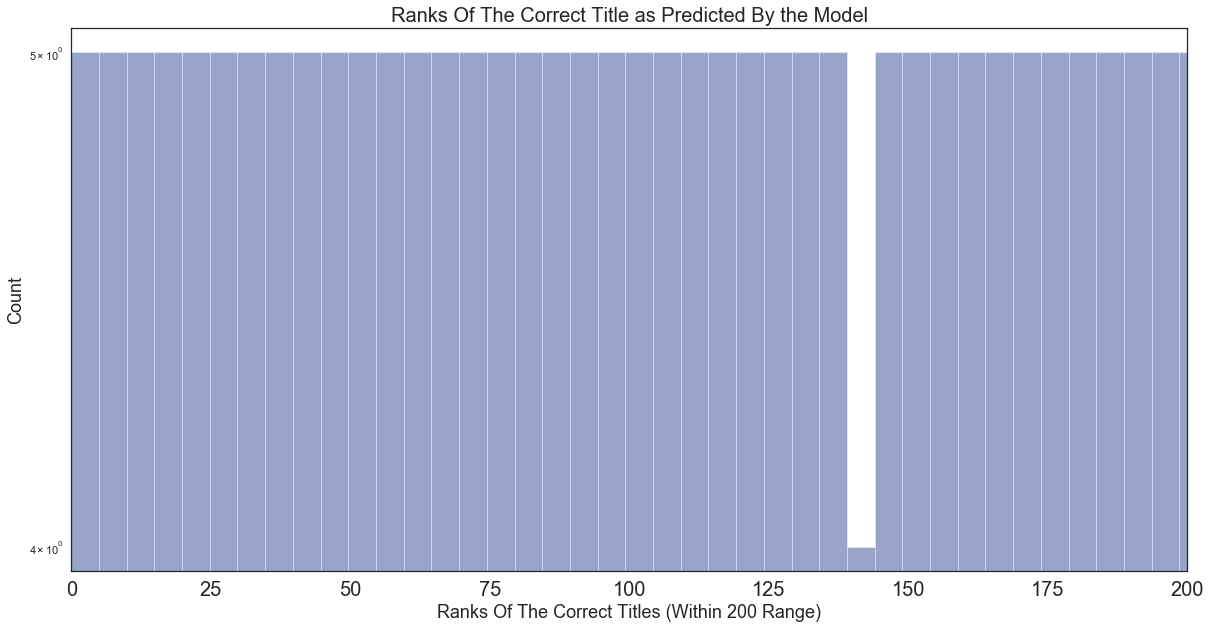

In [144]:
lr_ranks, lr_small = ranks_evaluation(test_sample_vectorized, lr_test)

## 2. Random Forest

In [145]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1200,
                            max_depth = 30)

rfc_test.fit(X_train_pca, new_y_training)

print('Accuracy:', rfc_test.score(X_test_pca, new_y_test))

Accuracy: 0.9299610894941635


In [146]:
rfc_pred = rfc_test.predict(X_test_pca)
print(confusion_matrix(new_y_test, rfc_pred ))

[[26843  1685]
 [ 2311 26215]]


In [147]:
print('F1 Score:', f1_score(new_y_test, rfc_pred ))

F1 Score: 0.9291815829582107


In [148]:
print('Precision score:', precision_score(new_y_test, rfc_pred ))

Precision score: 0.9396057347670251


In [149]:
print('Recall score:', recall_score(new_y_test, rfc_pred ))

Recall score: 0.918986188038982


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Mean Rank:  22.994969818913482
Proportion of the Correct Titles In The Top Three Results:  0.6861167002012073


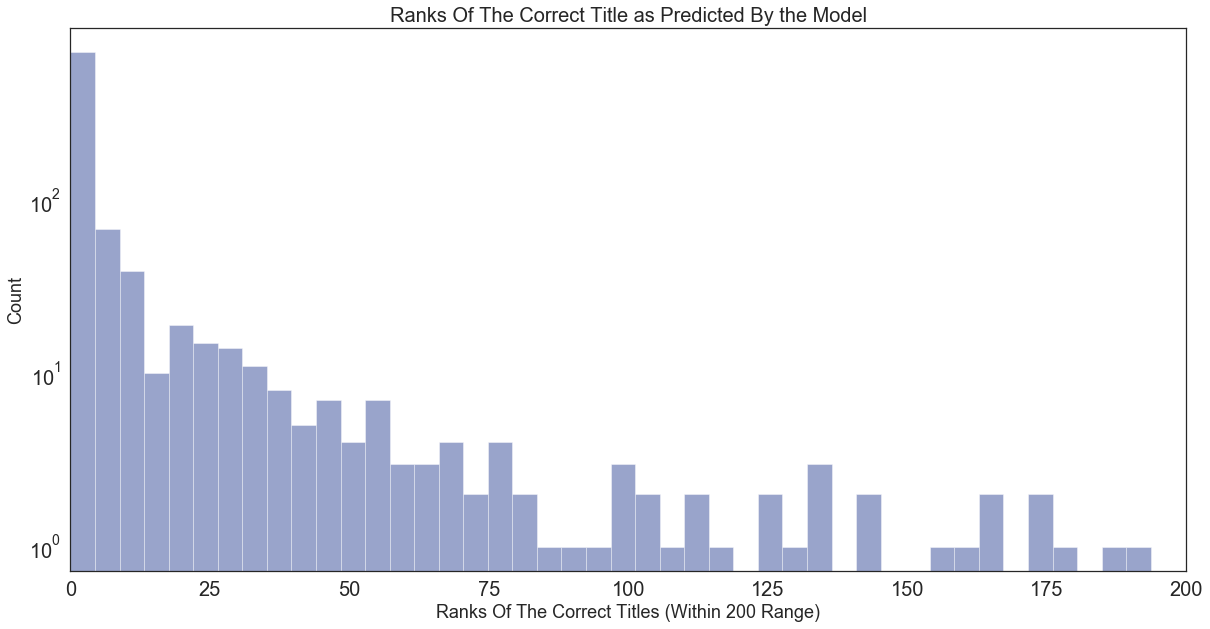

In [150]:
rfc_ranks, rfc_small = ranks_evaluation(test_sample_vectorized, rfc_test)

## 3. XGBoost

In [151]:
xgb_test = XGBClassifier(n_estimators = 1000,
                        max_depth = 8,
                        learning_rate= 0.1,
                        subsample = 0.5)

xgb_test.fit(X_train_pca, new_y_training)

print('Accuracy:', xgb_test.score(X_test_pca, new_y_test))

Accuracy: 0.9678725418025029


In [152]:
xgb_pred = xgb_test.predict(X_test_pca)
print('F1 Score:', f1_score(new_y_test, xgb_pred ))

F1 Score: 0.9677294413830742


In [153]:
print(confusion_matrix(new_y_test, xgb_pred))

[[27737   791]
 [ 1042 27484]]


In [154]:
print('Precision score:', precision_score(new_y_test, xgb_pred))

Precision score: 0.972024756852343


In [155]:
print('Recall score:', recall_score(new_y_test, xgb_pred))

Recall score: 0.9634719203533618


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)
Mean Rank:  10.359154929577464
Proportion of the Correct Titles In The Top Three Results:  0.8551307847082495


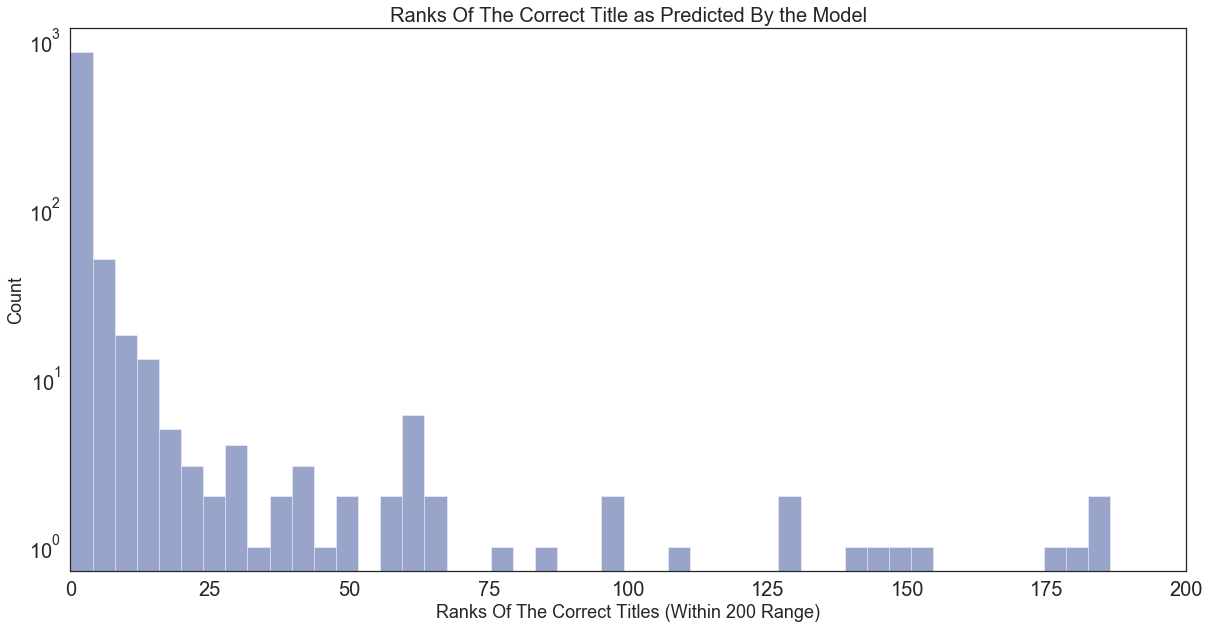

In [156]:
xgb_ranks, xgb_small = ranks_evaluation(test_sample_vectorized, xgb_test)

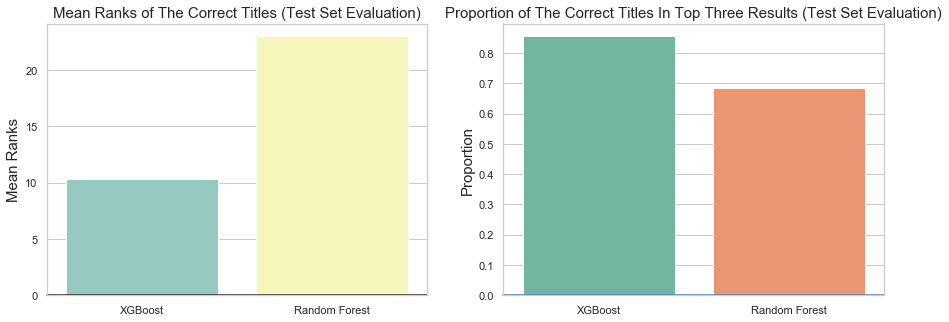

In [330]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.set(style="whitegrid")
x = np.array(['XGBoost','Random Forest'])
y1 = np.array([10.359, 22.99] )
ax1= sns.barplot(x=x, y=y1, palette="Set3")
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")
plt.title('Mean Ranks of The Correct Titles (Test Set Evaluation)', fontsize=15)
plt.ylabel('Mean Ranks', fontsize=15)

plt.subplot(122)
x = np.array(['XGBoost','Random Forest'])
y1 = np.array([0.855, 0.686] )
ax1= sns.barplot(x=x, y=y1, palette="Set2")
ax1.axhline(0, color="b", clip_on=False)
ax1.set_ylabel("Sequential")
plt.title('Proportion of The Correct Titles In Top Three Results (Test Set Evaluation)', fontsize=15)
plt.ylabel('Proportion', fontsize=15)

plt.show()

While Logistic Regression performed poorly (as was already to be expected based on the training set evaluation), XGBoost and Random Forest had good results. XGBoost with the mean rank of the correct title of `10.359` outperformed Random Forest with the mean rank of `22.99`.

If we ask, how often do our classifiers return the correct title in the top three results, then our XGBoost will have a higher proportion of `0.855` vs. the Random Forest model with the proportion of `0.686`. 

# VII.  RNN Solution

We could also solve the same problem by building a recurrent neural network. These networks are good for working with `sequences` and are, therefore, ideal for natural language processing, since language material is sequential. RNNs process “sequences explicitly as sequences”. In our case, we can feed a sequence of word vectors to it, one word vector at a time and not a sequence all at once (as we would do with other models).

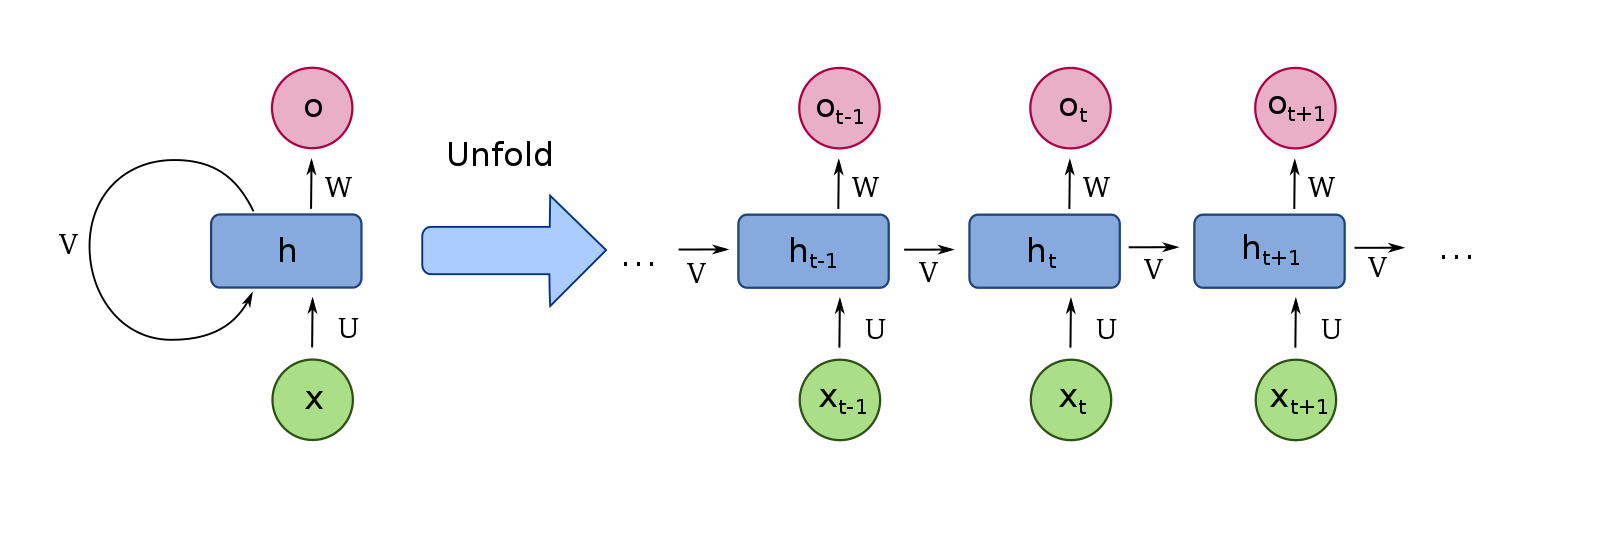

In [278]:
path = '/Users/admin/Documents/Recurrent.png'
Image(filename = path, width=600, height=300)

Image by François Deloche, distributed under a CC-BY 2.0 license.

Generally speaking, RNNs have a `temporal` or `memory` aspect to it. “The hidden layer from the previous timestep provides a form of memory, or context, that encodes earlier processing and informs the decisions to be made at later points in time.” “The context embodied in the previous hidden layer includes information extending back to the beginning of the sequence”. So, each neuron receives an input and information from the hidden layer from a previous timestamp (‘memory’). We could design an RNN that predicts a class or produce sequences. 

In our case, we will, first, use an RNN to solve our classification problem: is an ad title and an ad text a match? Later, however, we will use this RNN’s unique ability to produce sequences and train it to generate new ad texts from scratch. 

<sub> Daniel Jurafsky and James H. Martin. Speech and Language Processing, 3rd ed. draft. (Stanford University / University of Colorado at Boulder, 2018), 177-179.  Accessed October 23, 2018. https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf 


## 1. Data Preprocessing

For our RNN, we will build a different pipeline. We will: 
- First, concatenate ad texts and ad titles. 
- For computational reasons, we will `select the most frequent words` in the vocabulary and create individual indices for them. Then, each concatenated combo of ad text + title will be converted into a `sequences of indices`, for example: 

[452,   114,  2127,  3187,   165,   209, 13,     9,    16,    12,    32,  2127,  3187,   165,   209, 13]. 
- These sequences will be `padded` to the same length (maximum length that occurs in our data). 
- We will create `embeddings matrix that will hold word vector values` for each indexed word from our most frequently used words. This embeddings matrix will later be used in the `Keras Embeddings layer` (to be used in ‘weights’).
- As for our outcome variable (0/1), we will convert it to categorical.

While RNNs can work with sequences of any (and different) lengths, we still have to do padding here because of how Keras works. Here, we will pad sequence to the max sequence length of 28 words.

In [159]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1


In [160]:
training_df_mixed.iloc[:5, 1]

0           [дом, путешественник, ярославль]
1                  [чайник, sinbo, sk, 7310]
2                   [keneksi, m2, 40, 25, р]
3                        [семя, колокольчик]
4    [смартфон, lenovo, a7000, a, black, ds]
Name: title vectors, dtype: object

In [161]:
merged_trainig_examples = training_df_mixed.iloc[:, 1]+training_df_mixed.iloc[:, 0]

In [162]:
len(merged_trainig_examples)

133879

In [163]:
merged_test_examples = test_df_mixed.iloc[:, 1]+test_df_mixed.iloc[:, 0]

In [164]:
len(merged_test_examples)

57378

In [167]:
training_df_mixed['concatenated_text_title'] = training_df_mixed['text vectors'] + training_df_mixed['title vectors']

In [168]:
test_df_mixed['concatenated_text_title'] = test_df_mixed['text vectors'] + test_df_mixed['title vectors']

In [169]:
test_df_mixed['concatenated_text_title'].head()

0    [bosch, smv, 65m30, от, 1642, 84, доставка, bo...
1    [быть, в, наличие, плиткорез, на, монорельс, 6...
2    [купить, баня, из, брус, под, ключ, высокий, к...
3    [купить, thrustmaster, джойстик, thrustmaster,...
4    [свитшот, в, интернет, магазин, 3d, футболка, ...
Name: concatenated_text_title, dtype: object

In [170]:
training_df_mixed.head()

,text vectors,title vectors,pair class,concatenated_text_title
0,"[цена, от, 450, руб, сут, бронировать, хостеть...","[дом, путешественник, ярославль]",1,"[цена, от, 450, руб, сут, бронировать, хостеть..."
1,"[за, 1400, руб, доставка]","[чайник, sinbo, sk, 7310]",1,"[за, 1400, руб, доставка, чайник, sinbo, sk, 7..."
2,"[мобильный, телефон, keneksi, m2, 40, 25, р, г...","[keneksi, m2, 40, 25, р]",1,"[мобильный, телефон, keneksi, m2, 40, 25, р, г..."
3,"[семя, колокольчик, сравнивать, цена, весь, ин...","[семя, колокольчик]",1,"[семя, колокольчик, сравнивать, цена, весь, ин..."
4,"[купить, lenovo, смартфон, lenovo, a7000, a, b...","[смартфон, lenovo, a7000, a, black, ds]",1,"[купить, lenovo, смартфон, lenovo, a7000, a, b..."


In [171]:
training_df_mixed['concatenated_text_title'][3]

['семя',
 'колокольчик',
 'сравнивать',
 'цена',
 'весь',
 'интернет',
 'магазин',
 'на',
 'семя',
 'семя',
 'колокольчик']

In [172]:
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences

In [173]:
from keras.utils import to_categorical
y_reshaped_tr = to_categorical(training_df_mixed['pair class'], 2)
y_reshaped_test = to_categorical(test_df_mixed['pair class'], 2)

In [174]:
word_vectors = model.wv

In [175]:
len(word_vectors['нужно'])

300

In [176]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 19849


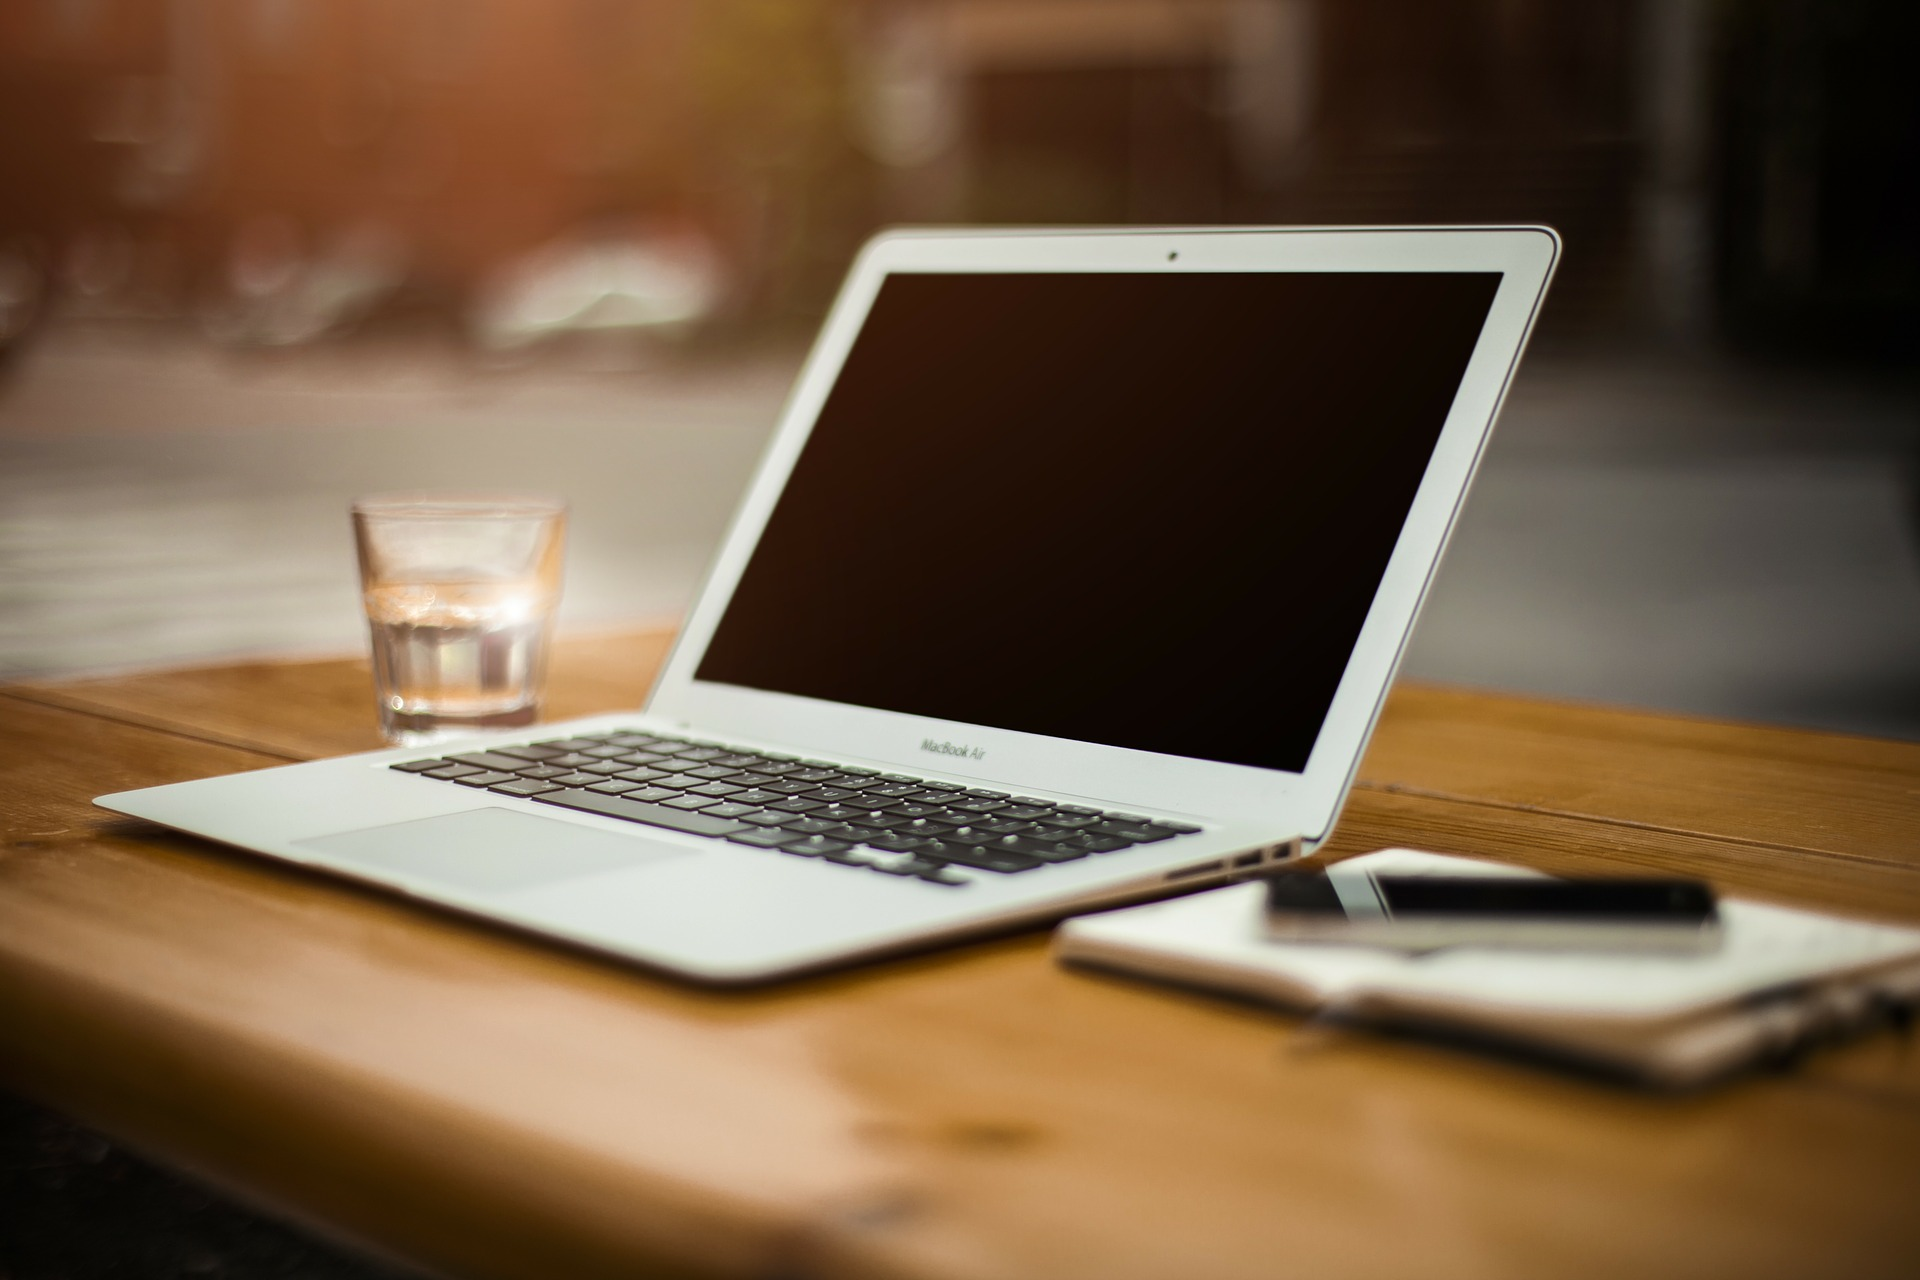

In [295]:
path = '/Users/admin/Documents/comp.jpg'
Image(filename = path, width=300, height=600)

It doesn't hurt to check that our model produces meaningful results. So, for 'computer', it returns the most similar words 'setting,' 'minecraft,' 'fix,' 'administrator,' and 'support.' Not bad!

In [177]:
model.wv.most_similar_cosmul(positive=['компьютер']) 

[('настройка', 0.7767220139503479),
 ('майнкрафт', 0.748451292514801),
 ('починять', 0.7481715083122253),
 ('администратор', 0.7424825429916382),
 ('обслуживание', 0.7337552309036255),
 ('чистка', 0.7295207977294922),
 ('windows', 0.7243865728378296),
 ('аутсорсинг', 0.7205873727798462),
 ('приезжать', 0.719767689704895),
 ('если', 0.7194758653640747)]

## Counting and Indexing

We will count the most frequent words in the vocabulary and create word_indices for them. Then, we will convert word sequences into indexed sequences for our training and test sets respectively. For computational reasons, we cannot keep information about all the words that occur in our data.

In [178]:
MAX_NB_WORDS = len(word_vectors.vocab)

In [179]:
from collections import Counter
vocab=Counter()

for entry in training_df_mixed['concatenated_text_title']:
    vocab.update(entry)

In [180]:
MAX_NB_WORDS

19849

In [181]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [182]:
training_sequences = [[word_index.get(t, 0) for t in ad_title_combo]
             for ad_title_combo in training_df_mixed['concatenated_text_title']]

In [183]:
test_sequences = [[word_index.get(t, 0)  for t in ad_title_combo] 
                  for ad_title_combo in test_df_mixed['concatenated_text_title']]

In [184]:
max([len(x) for x in training_sequences])

28

In [185]:
max([len(x) for x in test_sequences])

28

In [186]:
MAX_SEQUENCE_LENGTH = 28

In [187]:
# pad sequences
data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre")

In [188]:
data[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     1,    11,  1055,    15,
          384,   304,  3866,    63,     0,    49,   387,    63,     0,
         1582],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    22,  1837,    15,     7,   192,   735,  2651,
        14518],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   452,   114,  2127,  3187,   165,   209,
           13,     9,    16,    12,    32,  2127,  3187,   165,   209,
           13],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  1101,
            0,     8,     1,     5,     6,     4,    14,  1101,  1101,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

In [189]:
data.shape

(133879, 28)

In [190]:
# pad sequences
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre")

In [191]:
test_data.shape

(57378, 28)

In [192]:
y_reshaped_tr.shape

(133879, 2)

In [193]:
y_reshaped_test.shape

(57378, 2)

In [194]:
MAX_NB_WORDS

19849

In [195]:
len(word_vectors.vocab)

19849

In [196]:
WV_DIM = 300

In [197]:
length_maxtrix = len(word_vectors.vocab)+1

embedding_matrix = np.zeros((length_maxtrix, 300))

for word, i in word_index.items():
    if i <= MAX_NB_WORDS:
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        if embedding_vector is None:
            embedding_matrix[i] = np.zeros(300)

In [198]:
embedding_matrix.shape

(19850, 300)

## 2. Model Training

We will use Gated Recurrent Unit (`GRU`) which is a more recently introduced type of RNN (proposed in 2014). A simple recurrent network knows everything from the sequence up until this moment (“the context of the network to the left of the current time”). Here we will create a `bidirectional` RNNs which actually includes two recurrent networks: one processes the sequence left to right whereas the other processes the same sequence right to left. In the end, we combine the outputs from the hidden states of these models. Bidirectional RNNs are an effective option for classification tasks.

<sub>Daniel Jurafsky and James H. Martin. Speech and Language Processing, 3rd ed. draft. (Stanford University / University of Colorado at Boulder, 2018), 187-8. Accessed October 23, 2018. https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf <sub>

We will employ several techniques to try prevent overfitting, including `dropout` layer and `batch normalization`. 

In [199]:
from keras.layers import Dense, Input, Embedding, Dropout,  GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

In [231]:
model_rnn = Sequential()
model_rnn.add(Embedding(MAX_NB_WORDS+1,
                     WV_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))

model_rnn.add(Bidirectional(GRU(500)))
model_rnn.add(Dropout(0.5))

model_rnn.add(BatchNormalization())
model_rnn.add(Dense(2, activation = 'softmax', 
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=regularizers.l1(0.01))

model_rnn.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy']) 

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, 
                          verbose=1, mode='auto') 
callbacks_list = [earlystop]

In [232]:
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 300)           5955000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000)              2403000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2002      
Total params: 8,364,002
Trainable params: 2,407,002
Non-trainable params: 5,957,000
_________________________________________________________________


In [233]:
len(y_reshaped_tr)

133879

In [234]:
model_info = model_rnn.fit(data, y_reshaped_tr, 
               verbose = 1, 
               epochs=15, 
               batch_size=256,
               shuffle=True,
               callbacks=callbacks_list,
               validation_data = (test_data, y_reshaped_test))

Train on 133879 samples, validate on 57378 samples
Epoch 1/15
133879/133879 [==============================] - 583s 4ms/step - loss: 0.3592 - acc: 0.8336 - val_loss: 0.1771 - val_acc: 0.9352
Epoch 2/15
133879/133879 [==============================] - 560s 4ms/step - loss: 0.1260 - acc: 0.9539 - val_loss: 0.1276 - val_acc: 0.9544
Epoch 3/15
133879/133879 [==============================] - 558s 4ms/step - loss: 0.0728 - acc: 0.9739 - val_loss: 0.1041 - val_acc: 0.9623
Epoch 4/15
133879/133879 [==============================] - 555s 4ms/step - loss: 0.0467 - acc: 0.9832 - val_loss: 0.1146 - val_acc: 0.9636
Epoch 5/15
133879/133879 [==============================] - 574s 4ms/step - loss: 0.0337 - acc: 0.9882 - val_loss: 0.1187 - val_acc: 0.9637
Epoch 6/15
133879/133879 [==============================] - 610s 5ms/step - loss: 0.0264 - acc: 0.9910 - val_loss: 0.1324 - val_acc: 0.9637
Epoch 7/15
133879/133879 [==============================] - 562s 4ms/step - loss: 0.0231 - acc: 0.9924 - val_

## 3. Model Evaluation

For the RNN, we will also create a separate pipeline for ranking evaluation. 
- We will take a random sample of 1000 examples. 
- For each ad text, we will concatenate it with 1000 potential ad titles
- Convert these sequences into indexed sequences
- Pad them and use our pre-trained RNN to compute probability of this combination being a ‘match or correct pair. 
- Afterwards, we will compute the rank of the correct title. 
- We will repeat this process for each ad text in our sample. 
- In the end, we will be able to compute the `mean rank of the correct title` and `the percentage of the correct titles in the top three results`. 

In [235]:
def probability_calculator_rnn(text_vector, title_vectors, model):
    list_concat_arrays = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        list_concat_arrays.append(resultant_array)
    
    made_array = np.array(list_concat_arrays)
    sequences = [[word_index.get(t, 0) for t in combo]
                         for combo in  made_array]
    
    training_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre")         
    predictions = model.predict(training_padded)[:, 1]
        
    return predictions

In [236]:
def rank_checker_rnn (df, number, model):
    probabilities = probability_calculator_rnn(df.iloc[number, 0], df.iloc[:, 1], model)
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [237]:
ranks_rnn = []
for row in range(len(sample_test_df_checking)):     
    rank = rank_checker_rnn(sample_test_df_checking, row, model_rnn)

    ranks_rnn.append(rank)

In [238]:
np.mean(ranks_rnn)

10.835

In [239]:
small_rnn = []
for rank in ranks_rnn:
    if rank <=3:
        small_rnn.append(rank)

In [240]:
len(small_rnn)/ len(ranks_rnn)

0.79

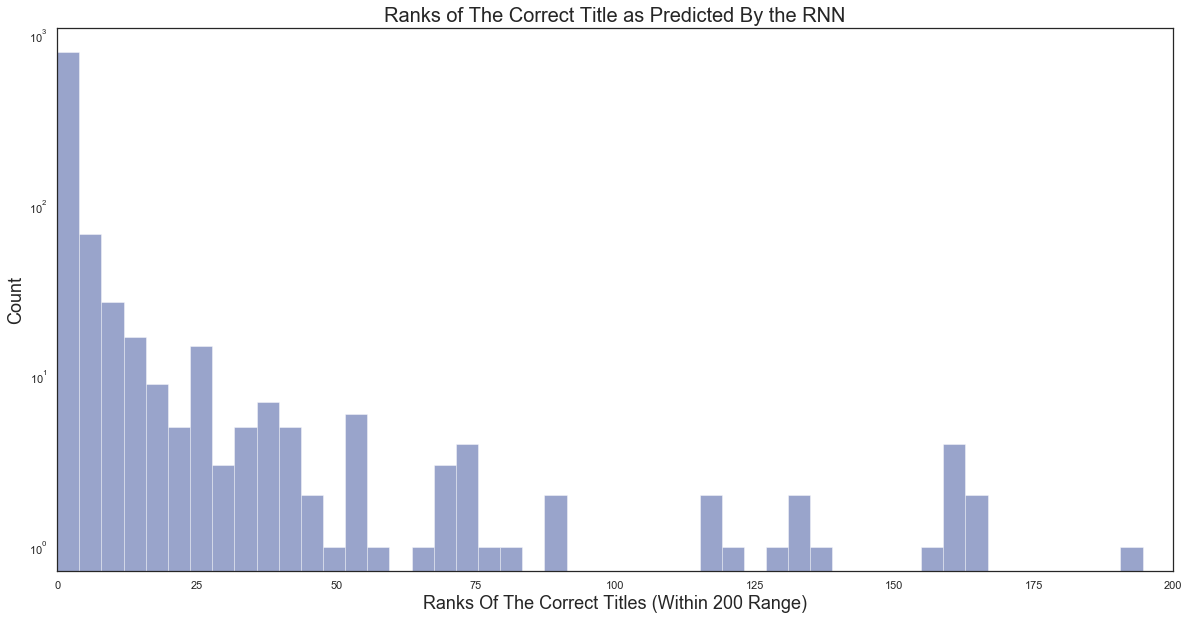

In [241]:
plt.figure(figsize=(20, 10))
sns.set(style="white", palette="dark", color_codes=True)
ax = sns.distplot(ranks_rnn, bins =200, kde=False) 
ax.set_yscale('log', basey=10)

plt.xlim(0,200)
plt.xlabel('Ranks Of The Correct Titles (Within 200 Range)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Ranks of The Correct Title as Predicted By the RNN', fontsize=20)

plt.show()

In [242]:
predictions = []
for prob in model_rnn.predict(test_data)[:, :]:
    if prob[0] > prob[1]:
        predictions.append(0)
    else:
        predictions.append(1)

In [243]:
len(predictions)

57378

In [244]:
len(test_df_mixed['pair class'])

57378

In [245]:
print('F1 Score:', f1_score(test_df_mixed['pair class'], predictions ))

F1 Score: 0.9639428950399666


In [246]:
print(confusion_matrix(test_df_mixed['pair class'], predictions))

[[27696   993]
 [ 1073 27616]]


In [247]:
print('Precision score:', precision_score(test_df_mixed['pair class'], predictions))

Precision score: 0.9652906428047118


In [248]:
print('Recall score:', recall_score(test_df_mixed['pair class'], predictions))

Recall score: 0.9625989055038516


# Results

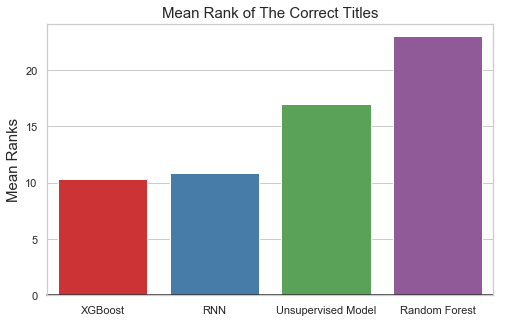

In [378]:
plt.figure(figsize=(8, 5))

sns.set(style="whitegrid")
x = np.array(['XGBoost', 'RNN','Unsupervised Model','Random Forest'])
y1 = np.array([10.359, 10.835, 16.957, 22.99] ) 

ax1= sns.barplot(x=x, y=y1, palette="Set1")
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")
plt.title('Mean Rank of The Correct Titles', fontsize=15)
plt.ylabel('Mean Ranks', fontsize=15)
plt.show()

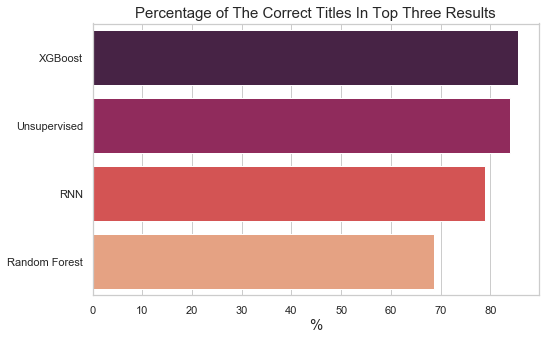

In [376]:
plt.figure(figsize=(8, 5))
x = np.array(['XGBoost','Unsupervised', 'RNN','Random Forest'])
y1 = np.array([85.5, 84, 79,  68.6] )
ax1= sns.barplot(x=y1, y=x,  palette="rocket")
ax.set_xlabel(y1)
#ax1.axhline(0, color="b", clip_on=False)
#ax1.set_ylabel("Sequential")
plt.title('Percentage of The Correct Titles In Top Three Results', fontsize=15)
plt.xlabel('%', fontsize=15)
plt.show()

The final outcomes for our supervised solutions stand as follows:

**Supervised Models:**

- 1) XGBoost with the mean rank of `10.359` and the proportion of the correct titles in the top three results of `0.855` outperformed other models. 
- 2) RNN became our second best model with the mean rank of `10.835` and the proportion of the correct title in top three results of `0.79`. 
- 3) Random Forest came third (`22.99` and `0.686`). 

**Unsupervised Model (Cosine Similarity):**
 - Mean rank of the correct tile - `16.957`, proportion of the correct titles in top three results - `0.84`.
 
**WHAT WE CAN DO NOW:**

We can suggest a matching title in top three recommendations for an advertisement text for `85.5%` of the cases in the test!

## NEXT STEPS

Despite the fact that the RNN did not turn out to be the best model for a supervised classification task, it was useful to learn the pipeline of working with an RNN, which we will adapt for a Text Generation task - the task that an RNN can tackle. In the part 2 of the project (see link), we will create `an ad text generator`.